# Who feeds the world ? And how wealthy are they ?
There are **folium maps** in this notebook. If they do not display or do not display well, we suggest you to **have a look at the `.html` file** that is located the same repository.

## Abstract <a name="abstract"></a>

Are countries that plant more maize richer than countries planting rice? Is it true that developed countries produce more meat? Are you better off being a food net exporter or importer? Are food prices more stable if you produce more food locally or trade more?

In this project we analyze **the effects that a country agricultural sector has on its different economic indicators**. The indicators of the agricultural sector we used are crops and livestock **production, exports and imports** of **crops, livestock and live animals**. For these, we use the data from the "**Global Food & Agriculture Statistics**" datasets. We quantify the **economic success** by **Gross Domestic Product (GDP)**, but also by **price stability**, as defined by low changes in **Consumer Price Indices (CPI)**. We further use the **Food and Agriculture Organization (FAO)** definition of **food self-sufficiency** to analyze its link to economic success and stability. 
After finding the results of the agricultural products most highly linked with economic success, we create **visualizations** in the form of **maps**. Through these timeline maps, we show how the production/export/import of important products has developed globally. We also use maps to visualize the **level of food self-sufficiency and price stability**.




## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- Which **agricultural products** are the **most produced/exported/imported** globally?
- Which of them are **correlated more highly with GDP**?
- Can we **predict** which countries will have **further GDP growth** based on the repartition of their agricultural sector?
- How can we define **price stability**? How can we define **food self-sufficiency**? Is there a link?
- What is countries **agricultural trade balance**? Are countries that are net exporters or importers richer ? Are self-sufficient countries **richer** ?
- How does the geographical repartition of important agricultural products look like? Which countries are **net food exporters or importers**? How did this **evolve over the last few decades** ?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
    
    7. [The last filter](#1G)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)  
                
    3. [Structure of international trade and historical context](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Identifying the most important features](#3A)
        1. [Feature selection and model fitting](#3Aa)
        2. [Results](#3Ab)

    2. [Where are the most important feature produced?](#3B)

    3. [Who are the net importers and exporters of the features of interest?](#3C)

    4. [How is the self sufficiency score distributed for the selected features?](#3D)      


**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display
import scipy.cluster.hierarchy as spc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from operator import itemgetter
from sklearn import preprocessing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

**Setup:**

In [2]:
data_folder_path = "Scripts/Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Food trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Consumer price indices" : "ConsumerPriceIndices_E_All_Data_(Normalized).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unuseful data](#1Da)         
        
        2. [Handling of the missing data](#1Db)       
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset is a subset of the **"Global Food & Agriculture Statistics"** that is found **in the proposed datasets list**. In this dataset, we have seen that we could work with the **production** as well as **import** and **export** quantities **per year** and **per country**. As far as food is concerned, we use **crops**, **livestock** and **live animals**. We have also found pieces of information about countries **GDP** and **CPI** in this database.

This database countains several files. We had a look of all the files. For food-related data about countries, we decided to focus on the following files:
- `Production_Crops_E_All_Data_(Normalized).csv` contains data about **crops production**.
- `Trade_Crops_Livestock_E_All_Data_(Normalized).csv` contains data about **food trade** (crops and livestock).
- `Production_Livestock_E_All_Data_(Normalized).csv` contains data about **livestock production**.
- `Trade_LiveAnimals_E_All_Data_(Normalized).csv` contains data about **live animals trade**.

For food-related data about countries, we decided to focus on the following files:
- `ConsumerPriceIndices_E_All_Data_(Normalized).csv` contains data about **consumer price indices (CPI)**.
- `Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv` contains data about **gross domestic product (GDP)** along with other macroeconomic indicators.

### 1.B. Loading the data set  <a name="1B"></a>

In [3]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We **load each interresting dataset** in the dictionary `df` :

In [4]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to **get a first sense of the data**.

In [5]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [6]:
display_df(df, interesting_datasets)

'Crops production'

Area Code                     Area  Item Code  \
1137787        143                  Morocco        536   
2360113       5403          Southern Europe       1800   
694932          84                   Greece        544   
2430410       5502                Melanesia       1735   
2419672       5501  Australia & New Zealand       1735   

                             Item  Element Code     Element  Year Code  Year  \
1137787           Plums and sloes          5419       Yield       1986  1986   
2360113  Vegetables&Melons, Total          5419       Yield       1994  1994   
694932               Strawberries          5510  Production       1993  1993   
2430410        Vegetables Primary          5510  Production       1981  1981   
2419672        Vegetables Primary          5510  Production       2003  2003   

           Unit      Value Flag  
1137787   hg/ha    69231.0   Fc  
2360113   hg/ha   211230.0   Fc  
694932   tonnes     8800.0  NaN  
2430410  tonnes   313236.0    A  
2419672  tonnes  2727425.0    A

'Food trade'

Area Code                       Area  Item Code  \
914826          255                    Belgium         95   
13448606       5402            Northern Europe        103   
2838729         107              Côte d'Ivoire        222   
14163088       5801  Least Developed Countries       1061   
2471356         214  China, Taiwan Province of        870   

                                          Item  Element Code          Element  \
914826                            Flour, fonio          5922     Export Value   
13448606                          Grain, mixed          5910  Export Quantity   
2838729                    Walnuts, with shell          5910  Export Quantity   
14163088                 Meat, chicken, canned          5922     Export Value   
2471356   Meat, cattle, boneless (beef & veal)          5622     Import Value   

          Year Code  Year      Unit  Value Flag  
914826         2001  2001  1000 US$    0.0  NaN  
13448606       1993  1993    tonnes  311.0    A  
2838729        1993  1993    tonnes    NaN    M  
14163088       1977  1977  1000 US$    0.0    A  
2471356        1963  1963  1000 US$    0.0  NaN

'Consumer price indices'

Area Code                Area  Item Code  \
44720        185  Russian Federation      23012   
16682         60         El Salvador      23012   
33949        136          Mauritania      23013   
38690        158               Niger      23013   
51796        207            Suriname      23012   

                                                Item  Months Code    Months  \
44720  Consumer Prices, General Indices (2010 = 100)         7003     March   
16682  Consumer Prices, General Indices (2010 = 100)         7011  November   
33949     Consumer Prices, Food Indices (2010 = 100)         7005       May   
38690     Consumer Prices, Food Indices (2010 = 100)         7008    August   
51796  Consumer Prices, General Indices (2010 = 100)         7004     April   

       Year Code  Year  Unit       Value Flag  Note  
44720       2004  2004   NaN   52.995002    X  2010  
16682       2016  2016   NaN  108.592720    X  2010  
33949       2015  2015   NaN   99.179728    X  2014  
38690       2005  2005   NaN   96.780000    X  2008  
51796       2001  2001   NaN   39.390961    X  2010

'Macroeconomy'

Area Code             Area  Item Code  \
417332        272           Serbia      22076   
490557        226           Uganda      22008   
399312        189      Saint Lucia      22016   
319446        144       Mozambique      22075   
104719         41  China, mainland      22015   

                                                     Item  Element Code  \
417332  Value Added (Manufacture of food, beverages an...          6114   
490557                             Gross Domestic Product          6131   
399312    Value Added (Agriculture, Forestry and Fishing)          6103   
319446                  Value Added (Total Manufacturing)          6114   
104719                      Gross Fixed Capital Formation          6156   

                                          Element  Year Code  Year      Unit  \
417332          Value Local Currency, 2005 prices       1977  1977  millions   
490557             Annual growth US$, 2005 prices       2006  2006         %   
399312                        Share of GDP in US$       2015  2015         %   
319446          Value Local Currency, 2005 prices       1997  1997  millions   
104719  Annual growth Local Currency, 2005 prices       1978  1978         %   

              Value Flag  
417332          NaN  NaN  
490557     7.049361   Fc  
399312     2.311156   Fc  
319446  8265.084799  XAM  
104719    17.200000   Fc

'Livestock production'

Area Code                              Area  Item Code  \
115905        219                             Tonga       1034   
158134       5802  Land Locked Developing Countries        976   
19936          32                          Cameroon       1140   
90023         169                          Paraguay       1079   
140617       5207                     South America       1072   

                          Item  Element Code Element  Year Code  Year  \
115905                    Pigs          5111  Stocks       1995  1995   
158134                   Sheep          5111  Stocks       1994  1994   
19936        Rabbits and hares          5112  Stocks       1980  1980   
90023                  Turkeys          5112  Stocks       1974  1974   
140617  Geese and guinea fowls          5112  Stocks       1980  1980   

             Unit        Value Flag  
115905       Head      80853.0  NaN  
158134       Head  135347615.0    A  
19936   1000 Head          5.0    F  
90023   1000 Head         41.0  NaN  
140617  1000 Head        239.0    A

'Live animals trade'

Area Code                  Area  Item Code                     Item  \
146555         55              Dominica       1034                     Pigs   
349921        165              Pakistan       1882  Agricult.Products,Total   
599013       5305          Western Asia       1079                  Turkeys   
135588         51        Czechoslovakia        866                   Cattle   
99786          96  China, Hong Kong SAR       1083     Pigeons, other birds   

        Element Code          Element  Year Code  Year       Unit      Value  \
146555          5908  Export Quantity       1973  1973       Head        NaN   
349921          5622     Import Value       2002  2002   1000 US$  1563787.0   
599013          5909  Export Quantity       1987  1987  1000 Head        1.0   
135588          5608  Import Quantity       1963  1963       Head      300.0   
99786           5622     Import Value       2002  2002   1000 US$        0.0   

       Flag  
146555    M  
349921    A  
599013    A  
135588  NaN  
99786     *

At first glance, our datasets **seem very clean**.

Each of our dataset contains **a column "Year"** and a column that is named **"Area"**. This is a great news for us since we want to do a both **geographical and time-related analysis**.

The column **"Area"** correspond to the country except it **may contains a group of country** (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will **clean the datasets**. The **final goal is to produce one uniformized dataset** on which we could work (see [1.F.](#1F)).

In a very simplistic way, such a cleaned and uniformized dataset may look like this :

    Country | Year | GDP | CPI | Food production features | Food trade features

1.  
    4. 
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            3. [Extracting stocks production from the "Livestock production" dataset](#1Daiii)
            
            4. [Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets](#1Daiv)
            5. [Extracting average CPI of each year from the "Consumer price indices" dataset](#1Dav)
            
            6. [Removing areas which are not countries](#1Davi)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)     

#### 1.D.a. Removing unuseful data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes **without the unuseful data**.

In [7]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>
The "Macroeconomy" dataset contains **many different measures**: Gross Fixed Capital Formation, Gross National Income, Value Added (Total Manufacturing), ... We are **only interested in Gross Domestic Product**. Therefore, we extract it Gross Domestic Product from the "Macroeconomy" dataset. In order to have uniformisation among values, we choose the US$ value. All of them have the same unit (millions US\\$) so we can drop the "Unit" column as well.

In [8]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [9]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

We can have have a look at a sample of the extrated dataset:

In [10]:
display(df_useful["GDP"].sample(5))

Area Code                              Area  Year        Value
386538        146               Republic of Moldova  2007  4401.137824
562324       5504                         Polynesia  1970   332.897368
108960         45                           Comoros  2011  1085.576999
56665          19  Bolivia (Plurinational State of)  1970  1010.101010
420513        197                      Sierra Leone  2004  1448.538418

And we can plot GDP in million US$ for different countries for the period 1970-2015:

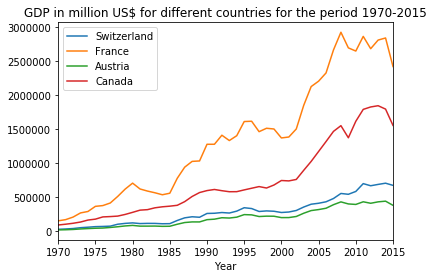

In [11]:
select_switzerland = df_useful["GDP"]['Area']=='Switzerland'
select_france = df_useful["GDP"]['Area']=='France'
select_austria = df_useful["GDP"]['Area']=='Austria'
select_canada = df_useful["GDP"]['Area']=='Canada'
ax = df_useful["GDP"][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('GDP in million US$ for different countries for the period 1970-2015')

For dissolute or new countries, we have some Nan values (before appearing or after dissolution) as in this next example :

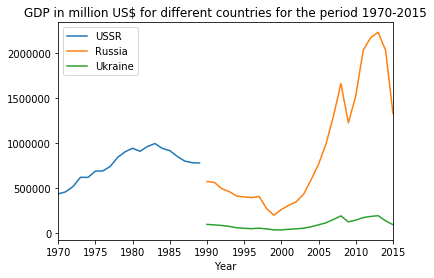

In [12]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('GDP in million US$ for different countries for the period 1970-2015')

##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>
We want to extract crops **harvested area**, **production**, **seed** and **yield** from the **"Crops production" dataset**. As all crops are not food crops, we request the [World crops database](https://world-crops.com/food-crops/) to **keep only the food crops**.

In [13]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [14]:
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

We check everything is fine by looking at samples for each of the new dataframes:

In [15]:
display('Crops Production', df_useful['Crops Production'].sample(5))

'Crops Production'

Area Code           Area                     Item  Year    Unit  \
2135718       5207  South America                   Lupins  1974  tonnes   
1833645        237       Viet Nam                Nuts, nes  1974  tonnes   
1229292        158          Niger  Fruit excl Melons,Total  2008  tonnes   
645235          74          Gabon   Groundnuts, with shell  1966  tonnes   
1665685        217           Togo  Cashew nuts, with shell  2009  tonnes   

            Value  
2135718    2381.0  
1833645    1000.0  
1229292  389097.0  
645235     3000.0  
1665685    3500.0

We also make some plots to have a first understanding of the dataset:

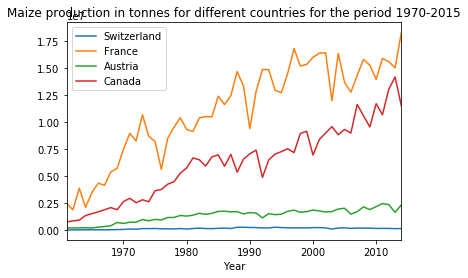

In [16]:
select_Maize = df_useful['Crops Production']['Item']=='Maize'
maize_df = df_useful['Crops Production'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Maize production in tonnes for different countries for the period 1970-2015')

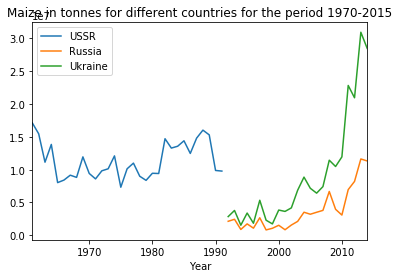

In [17]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('Maize in tonnes for different countries for the period 1970-2015')

##### 1.D.a.iii. Extracting stocks production from the "Livestock production" dataset<a name="1Daiii"></a>

We want to extract **stocks production** from the **"Livestock production" dataset**. Again, we drop the columns that are useless for us and have a first look of the data with a sample and some plots.

In [18]:
selection_stocks = df['Livestock production']["Element"] == 'Stocks'
df_useful['Livestock production'] = df['Livestock production'][selection_stocks].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [19]:
display(df_useful['Livestock production'].sample(5))

Area Code                          Area                    Item  Year  \
153234       5501       Australia & New Zealand    Cattle and Buffaloes  2012   
1342            3                       Albania    Cattle and Buffaloes  2007   
49346          87                    Guadeloupe       Rabbits and hares  1979   
122547        240  United States Virgin Islands                   Asses  1966   
143211       5302                  Eastern Asia  Geese and guinea fowls  2000   

             Unit       Value  
153234       Head  38598515.0  
1342         Head    577120.0  
49346   1000 Head        14.0  
122547       Head        38.0  
143211  1000 Head    203018.0

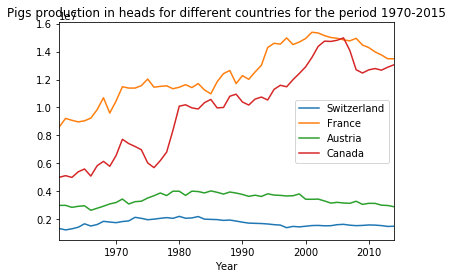

In [20]:
select_pigs = df_useful['Livestock production']['Item']=='Pigs'
pigs_df = df_useful['Livestock production'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Pigs production in heads for different countries for the period 1970-2015')

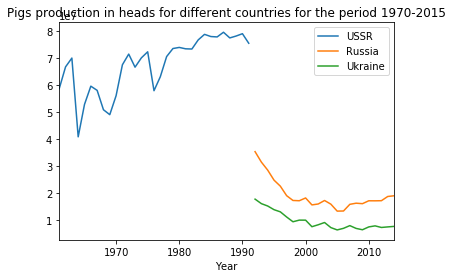

In [21]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('Pigs production in heads for different countries for the period 1970-2015')

##### 1.D.a.iv. Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets<a name="1Daiv"></a>
Now, we extract **import and export quantities** from the **"Live animals trade" and "Crops trade" datasets**, having again some samples and some plots.

In [22]:
selection_import_quantities = df['Live animals trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Live animals trade']["Element"] == 'Export Quantity'

df_useful['Live animals import quantities'] = df['Live animals trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Live animals export quantities'] = df['Live animals trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [23]:
display(df_useful['Live animals import quantities'].sample(5))

Area Code                              Area             Item  Year  \
260184        120  Lao People's Democratic Republic        Buffaloes  1999   
628068       5501           Australia & New Zealand            Goats  1964   
219467        100                             India           Horses  1994   
233995        105                            Israel            Goats  2000   
45828          23                            Belize  Bovine, Animals  2003   

        Unit  Value  
260184  Head    0.0  
628068  Head    0.0  
219467  Head    0.0  
233995  Head    0.0  
45828   Head   99.0

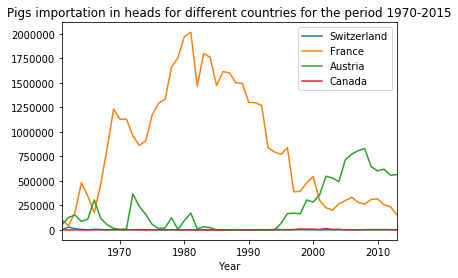

In [24]:
select_pigs = df_useful['Live animals import quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals import quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Pigs importation in heads for different countries for the period 1970-2015')

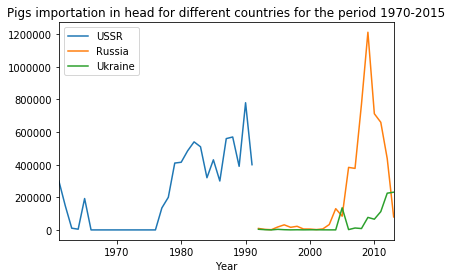

In [25]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('Pigs importation in head for different countries for the period 1970-2015')

In [26]:
display(df_useful['Live animals export quantities'].sample(5))

Area Code         Area              Item  Year       Unit  Value
188746         81        Ghana            Horses  2013       Head    5.0
198858         89    Guatemala            Cattle  2002       Head  107.0
393511        189  Saint Lucia   Bovine, Animals  1966       Head    0.0
172777         68       France  Animals live nes  1997       Head    NaN
36288          14     Barbados             Ducks  1997  1000 Head    NaN

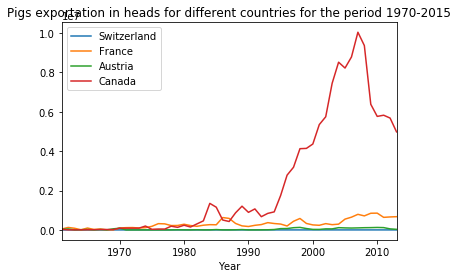

In [27]:
select_pigs = df_useful['Live animals export quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals export quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Pigs exportation in heads for different countries for the period 1970-2015')

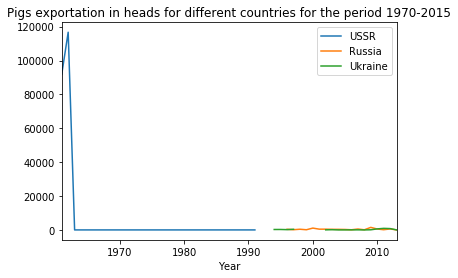

In [28]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('Pigs exportation in heads for different countries for the period 1970-2015')

In [29]:
selection_import_quantities = df['Food trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Food trade']["Element"] == 'Export Quantity'

df_useful['Food import quantities'] = df['Food trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Food export quantities'] = df['Food trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [30]:
display(df_useful['Food import quantities'].sample(5))

Area Code                  Area                            Item  \
1162531          18                Bhutan  Juice, citrus, single strength   
10550335        227                Tuvalu                     Animal fats   
2232062          96  China, Hong Kong SAR                    Juice, grape   
9892776         210                Sweden               Eggs in The Shell   
11083624        228                  USSR                Oilseed Cake nes   

          Year    Unit   Value  
1162531   1984  tonnes     NaN  
10550335  1965  tonnes     NaN  
2232062   1964  tonnes     0.0  
9892776   2001  tonnes  6387.0  
11083624  1962  tonnes     0.0

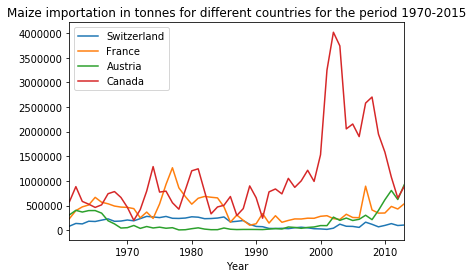

In [31]:
select_Maize = df_useful['Food import quantities']['Item']=='Maize'
maize_df = df_useful['Food import quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Maize importation in tonnes for different countries for the period 1970-2015')

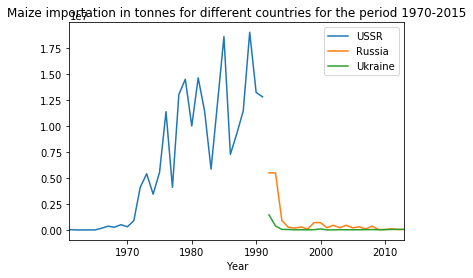

In [32]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('Maize importation in tonnes for different countries for the period 1970-2015')

In [33]:
display(df_useful['Food export quantities'].sample(5))

Area Code                      Area  \
4028991          74                     Gabon   
496791           10                 Australia   
10743119        229            United Kingdom   
10940026        231  United States of America   
4483559          89                 Guatemala   

                                          Item  Year    Unit   Value  
4028991                             Sugar, nes  1997  tonnes     NaN  
496791                                 Tobacco  2012  tonnes  4476.0  
10743119                              Avocados  2005  tonnes   683.0  
10940026  Meat, cattle, boneless (beef & veal)  1964  tonnes     0.0  
4483559                             Pineapples  1995  tonnes   196.0

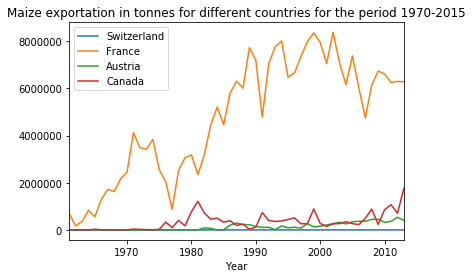

In [34]:
select_Maize = df_useful['Food export quantities']['Item']=='Maize'
maize_df = df_useful['Food export quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Maize exportation in tonnes for different countries for the period 1970-2015')

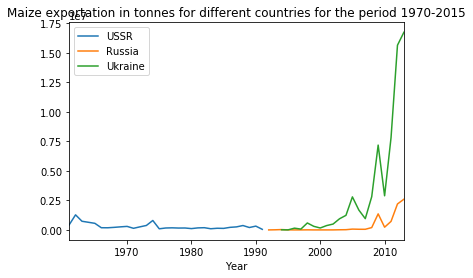

In [35]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('Maize exportation in tonnes for different countries for the period 1970-2015')

##### 1.D.a.v. Extracting average CPI of each year from the "Consumer price indices" dataset<a name="1Dav"></a>

The **"Consumer price indices" dataset** contains **monthly data**. In order to have a **uniform dataframe**, and as other dataframes have **yearly data**, we will group it by (Country, Year) and compute the monthly mean for every year. Then we add a column to show the relative change in CPI, as this is what measures inflation, according to the following formula:

$$\frac{CPI_t - CPI_{t-1}}{CPI_{t-1}}$$

In [36]:
df_useful['Consumer price indices'] =  df['Consumer price indices'][['Area','Year','Value']] \
                                        .dropna() \
                                        .groupby(['Area',"Year"]) \
                                        .mean() \
                                        .reset_index() \
                                        .dropna()

In [37]:

#We calculate the relative change in CPI for each year relative to last years CPI - this indicates yearly inflation. The first year in each area is set to 0.


df_useful['Consumer price indices']['Value'] = np.where(df_useful['Consumer price indices']['Area'] == df_useful['Consumer price indices']['Area'].shift(1),
         ((df_useful['Consumer price indices']['Value'] - df_useful['Consumer price indices']['Value'].shift(1))/df_useful['Consumer price indices']['Value'].shift(1)) * 100, 0)




In [38]:
display(df_useful['Consumer price indices'].head(5))

Area  Year      Value
0  Afghanistan  2004   0.000000
1  Afghanistan  2005  11.606340
2  Afghanistan  2006   7.254896
3  Afghanistan  2007   8.482889
4  Afghanistan  2008  30.554940

With samples and plots, we remark that this dataset **only starts in 2000** wheareas other ones start in 1970.

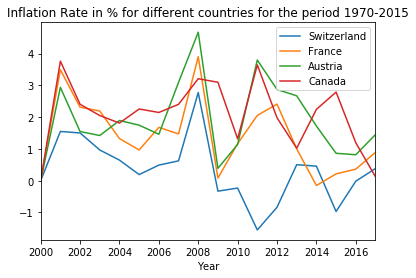

In [39]:
select_switzerland = df_useful['Consumer price indices']['Area']=='Switzerland'
select_france = df_useful['Consumer price indices']['Area']=='France'
select_austria = df_useful['Consumer price indices']['Area']=='Austria'
select_canada = df_useful['Consumer price indices']['Area']=='Canada'
ax = df_useful['Consumer price indices'][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful['Consumer price indices'][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["Switzerland", 'France', 'Austria', "Canada"])
_ = ax.set_title('Inflation Rate in % for different countries for the period 1970-2015')

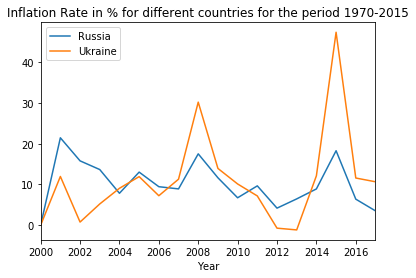

In [40]:
select_russia = df_useful["Consumer price indices"]['Area']=='Russian Federation'
select_ukraine = df_useful["Consumer price indices"]['Area']=='Ukraine'
ax = df_useful["Consumer price indices"][select_russia].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["Consumer price indices"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(['Russia', 'Ukraine'])
_ = ax.set_title('Inflation Rate in % for different countries for the period 1970-2015')

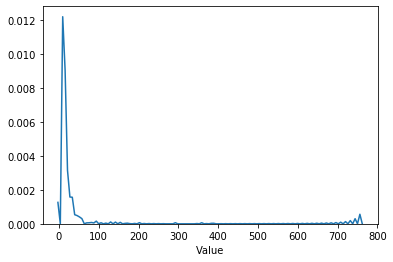

In [41]:
_ = sns.distplot(abs(df_useful["Consumer price indices"]["Value"]), rug=False, hist=False)

In [42]:
#looking at the cases where food prices increased over 100% during one year
df_useful["Consumer price indices"].loc[df_useful["Consumer price indices"]["Value"] > 100]

Area  Year       Value
55                                Angola  2001  152.561015
56                                Angola  2002  108.897433
851     Democratic Republic of the Congo  2001  359.936605
1280                              Guinea  2010  292.596028
2636               Sao Tome and Principe  2014  759.321212
2801                     Solomon Islands  2012  203.559117
2833                         South Sudan  2016  386.378414
2834                         South Sudan  2017  130.056890
3283  Venezuela (Bolivarian Republic of)  2015  171.224360
3284  Venezuela (Bolivarian Republic of)  2016  142.586732

It seems that the formula calculating food price inflation is actually correct. These are realistic cases where the price increased by over 100% in the span of a year. 

##### 1.D.a.vi. Removing areas which are not countries <a name="1Davi"></a>

Having a more detailled look at the dataset, we have remarked that the **areas which are real countries** are exactely the ones with an "Area Code" below $5000$ but not in $[261, 269]$.

In [43]:
#remove Area code >= 5000 or in [261, 269] (EU)
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<261 
        selection_countries = selection_countries | (df_useful[df_name]['Area Code']>269)
        selection_countries = selection_countries & (df_useful[df_name]['Area Code']<5000)
        df_useful[df_name] = df_useful[df_name][selection_countries]
        display(df_useful[df_name].sample(5))
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP


Area Code                 Area  Year         Value
61284          20             Botswana  1994   4259.258811
271021        125        Liechtenstein  1984    561.569352
478063        222              Tunisia  1975   4752.807682
475535        220  Trinidad and Tobago  2006  18369.105738
132408         51       Czechoslovakia  2007           NaN

Removing areas which are not countries in Crops Production


Area Code               Area                             Item  Year  \
1287236        166             Panama     Mangoes, mangosteens, guavas  1970   
464586          50             Cyprus  Melons, other (inc.cantaloupes)  1980   
1152375        144         Mozambique                         Tomatoes  1980   
104494          12            Bahamas                          Bananas  1979   
580700          61  Equatorial Guinea          Fruit excl Melons,Total  2002   

           Unit    Value  
1287236  tonnes  23009.0  
464586   tonnes   4877.0  
1152375  tonnes  13000.0  
104494   tonnes   7440.0  
580700   tonnes  55637.0

Removing areas which are not countries in Livestock production


Area Code       Area                    Item  Year       Unit  \
80721        149      Nepal                   Sheep  2000       Head   
4374           9  Argentina       Rabbits and hares  2014  1000 Head   
45858         79    Germany  Geese and guinea fowls  1977  1000 Head   
41639         67    Finland                Chickens  2010  1000 Head   
75680        138     Mexico         Sheep and Goats  2010       Head   

            Value  
80721    851913.0  
4374       1200.0  
45858       322.0  
41639      4616.0  
75680  17098783.0

Removing areas which are not countries in Live animals import quantities


Area Code          Area             Item  Year       Unit    Value
400943        194  Saudi Arabia        Buffaloes  1978       Head      NaN
281686        131      Malaysia         Chickens  1978  1000 Head  17140.0
269434        123       Liberia             Pigs  1971       Head      0.0
333420        158         Niger            Mules  2003       Head      NaN
334461        158         Niger  Bovine, Animals  1984       Head  30200.0

Removing areas which are not countries in Live animals export quantities


Area Code                      Area              Item  Year  \
429325         38                 Sri Lanka  Animals live nes  1986   
305166        143                   Morocco             Mules  1982   
37139          14                  Barbados              Pigs  2000   
383499        183                   Romania           Turkeys  2009   
493170        231  United States of America   Sheep and Goats  1961   

             Unit    Value  
429325       Head      0.0  
305166       Head      0.0  
37139        Head      0.0  
383499  1000 Head      0.0  
493170       Head  27858.0

Removing areas which are not countries in Food import quantities


Area Code            Area                          Item  Year  \
7207392        153   New Caledonia      Beverages, non alcoholic  2006   
9312447        198        Slovenia                 Peanut butter  2011   
339903           1         Armenia  Cabbages and other brassicas  2004   
7830425        165        Pakistan                Textile Fibres  1982   
162302           5  American Samoa               Coffee, roasted  1977   

           Unit    Value  
7207392  tonnes   4476.0  
9312447  tonnes     27.0  
339903   tonnes      0.0  
7830425  tonnes  62796.0  
162302   tonnes     78.0

Removing areas which are not countries in Food export quantities


Area Code                       Area  \
4244079         81                      Ghana   
8043757        170                       Peru   
2466467        214  China, Taiwan Province of   
3035170        167                    Czechia   
7979606        169                   Paraguay   

                                               Item  Year    Unit  Value  
4244079  Milk, products of natural constituents nes  1969  tonnes    NaN  
8043757                         Milk, skimmed dried  1989  tonnes    0.0  
2466467              Juice, pineapple, concentrated  2003  tonnes  478.0  
3035170                                Oil, linseed  2001  tonnes  408.0  
7979606                   Oil, vegetable origin nes  1968  tonnes    0.0

Consumer price indices is already clean


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will explain how we will handle the missing data in previous dataframes for maps.

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

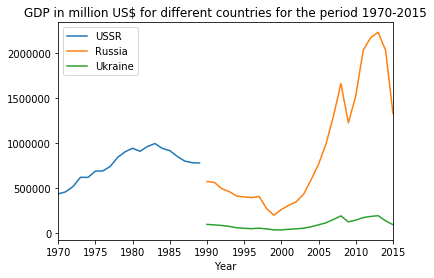

In [44]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
_ = ax.legend(["USSR", 'Russia', 'Ukraine'])
_ = ax.set_title('GDP in million US$ for different countries for the period 1970-2015')

In order to **vizualize folium maps**, we need to **associate each country a value**. The geojson file that we use is not timestamped and **only countries that exist nowadays** are inside it. As **some countries has been dissolved** during the past 50 years, our folium maps won't be complete. For instance, we do not have any value for Ukraine from 1970 to 1989. Our idea to fix this issue is presented in the next paragraph.

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 


Our idea is to **map the former country value to each of the current ones**. For instance in 1982, USSR GDP is around one trillion \\$. Therefore, if we associate (**only for folium map purposes**) this value to each current country that succeeded USSR, **all these countries will appear the same color** in the folium map, i.e. all the USSR area will appear the same color (and the good one).

In order to do so, one need to **identify which countries appeared and disappeared** from the dataset and **at which year**. Then we will use this result along with some **historical research** in our `visualise_world_data_folium` function ([1.E.a.](#1Ea)).

In [45]:
countries_formation_years = {}
for country in df_useful["GDP"]["Area"].unique():
    selection = df_useful["GDP"]["Area"] == country
    year_in, year_out = df_useful["GDP"][selection].dropna()["Year"].min(), df_useful["GDP"][selection].dropna()["Year"].max()
    for year in (year_in, year_out):
        if year not in countries_formation_years :
            countries_formation_years[year] = []
    countries_formation_years[year_in].append((country,'+'))
    countries_formation_years[year_out].append((country,'-'))

countries_formation_years.pop(1970)
countries_formation_years.pop(2015)
for year in sorted(list(countries_formation_years)):
    print (year, countries_formation_years[year])

1988 [('Yemen Ar Rp', '-'), ('Yemen Dem', '-')]
1989 [('Czechoslovakia', '-'), ('Ethiopia PDR', '-'), ('USSR', '-'), ('Yemen', '+'), ('Yugoslav SFR', '-')]
1990 [('Armenia', '+'), ('Azerbaijan', '+'), ('Belarus', '+'), ('Bosnia and Herzegovina', '+'), ('Croatia', '+'), ('Czechia', '+'), ('Eritrea', '+'), ('Estonia', '+'), ('Ethiopia', '+'), ('Georgia', '+'), ('Kazakhstan', '+'), ('Kyrgyzstan', '+'), ('Latvia', '+'), ('Lithuania', '+'), ('Montenegro', '+'), ('Republic of Moldova', '+'), ('Russian Federation', '+'), ('Serbia', '+'), ('Slovakia', '+'), ('Slovenia', '+'), ('Tajikistan', '+'), ('The former Yugoslav Republic of Macedonia', '+'), ('Timor-Leste', '+'), ('Turkmenistan', '+'), ('Ukraine', '+'), ('Uzbekistan', '+')]
1999 [('Kosovo', '+')]
2005 [('Curaçao', '+'), ('Sint Maarten (Dutch Part)', '+')]
2007 [('Sudan (former)', '-')]
2008 [('South Sudan', '+'), ('Sudan', '+')]
2012 [('Netherlands Antilles (former)', '-')]


### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with **country names** and **normalizing** the features.

1.  
    5. 
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>
Some countries have **different names in the geojson file and in the dataset**. We first start by correcting them.

In [46]:
# Useful method for name correction
def correct_country_names(old_name, dic):
    if old_name in dic.keys() :
        return dic[old_name]
    return old_name

In [47]:
# Declaring dictionary with name correction
dic = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea",
       'USSR':['Armenia',
               'Azerbaijan',
               'Belarus',
               'Estonia',
               'Georgia',
               'Kazakhstan',
               'Kyrgyzstan',
               'Latvia',
               'Lithuania',
               'Montenegro',
               'Republic of Moldova',
               'Russia',
               'Republic of Serbia',
               'Timor-Leste',
               'Turkmenistan',
               'Ukraine',
               'Uzbekistan'],
       'Ethiopia PDR':['Eritrea','Ethiopia'],
       'Yugoslav SFR':['Kosovo', 'Slovenia', 'Croatia','Macedonia', 'Bosnia and Herzegovina'],
       'Yemen Dem':['Yemen'],
       'Czechoslovakia':["Czech Republic", 'Slovakia'],
       'Netherlands Antilles (former)':['Curaçao', 'Sint Maarten (Dutch Part)'],
       'Sudan (former)':['South Sudan', 'Sudan']}

# Correcting each DataFrame
for df_name in df_useful :
    print (df_name)
    df_useful[df_name]["Area"] = df_useful[df_name]["Area"].apply(lambda x : correct_country_names(x,dic))
    df_useful[df_name]=df_useful[df_name].explode('Area')

GDP
Crops Production
Livestock production
Live animals import quantities
Live animals export quantities
Food import quantities
Food export quantities
Consumer price indices


Then, we do a function that takes as input **a dataframe and a year** and produces the **corresponding folium map**. This function also h**andles dissolutions of countries** as suggested [before](#1Dbii).

In [48]:
import matplotlib.colors as colors

def visualise_world_data_folium(df, to_visualise, year, units="", log=True,log2=False):
    
    if log2:
        log=False
    if log:
        log2=False
        
    # Defining color palette
    color_scale = sns.cubehelix_palette(9, start=.7, rot=-.9)
    
    # importing geojson and transforming to pandas
    geo_data=json.load(open("Scripts/Data/world-countries.json"))
    dics=geo_data['features']
    clean_dics=[]
    for country in dics:
        clean_dics.append({'Country':country['properties']['name'],
                          'geometry':country['geometry']})
    geo_df=pd.DataFrame(clean_dics)
    
    # cropping to df to data of interest
    df_visu=df[df.Year==year][['Area',to_visualise]]

    # Merging with geo data
    df_visu=geo_df.merge(df_visu,how='left',left_on='Country',right_on='Area')
    df_visu=df_visu.dropna()
    
    if log:
        df_visu['to_plot']=df_visu[to_visualise].apply(lambda x : np.log10(x))
        
    def log2_scale(x):
        out=np.sign(x)*np.log10(1+np.abs(x))
        return out
        
    if log2:
        df_visu['to_plot']=df_visu[to_visualise].apply(log2_scale)
    
    # creating bins for color scaling
    ma_value=df_visu['to_plot'].max()
    mi_value=df_visu['to_plot'].min()
    bins=np.linspace(mi_value,ma_value,8)
    
    # creating Json string for folium
    features=[]
    for _,row in df_visu.iterrows():
        color=np.digitize(row['to_plot'],bins)
        val=row[to_visualise]
        feature={
            'type' : 'Feature',
            
            'properties':{'Country':row['Country'],
                          '{}'.format(units): '{:.2E}'.format(val),
                          'color':colors.to_hex(color_scale[color])},
            'geometry':row['geometry']
            }
        features.append(feature)
    
    def style(feature):
        
        if feature['properties'][units]==np.nan:
            opac=0
        else:
            opac=0.8
        return {'fillOpacity':opac,
                   'weight':0.1,
                   'fillColor':feature['properties']['color']}
    geo_data=(folium.GeoJson({'type':'FeatureCollection','features':features},
                             style_function=style,
                             tooltip=folium.features.GeoJsonTooltip(['Country','{}'.format(units)])))
    m=folium.Map()
    geo_data.add_to(m)
    return m

We can know use it to produce some maps. For instance, we plot below the map of GDP for the year 1985 (before dissolution of USSR) and 1995 (after).

In [49]:
display(visualise_world_data_folium(df_useful["GDP"], 'Value', 1985,'GDP [Mil USD]' ,True))
display(visualise_world_data_folium(df_useful["GDP"], 'Value', 1995,'GDP [Mil USD]' ,True))

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

Some of our features **seem to be right skewed**. At first glance it seems that they look like power laws.

For instance the distribution of GDP look a bit like a power law:

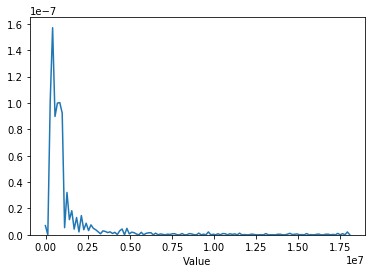

In [50]:
_ = sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

As we later want to train some Machine Learning models, we log those values so that their distribution look a bit **more like a normal distribution**.

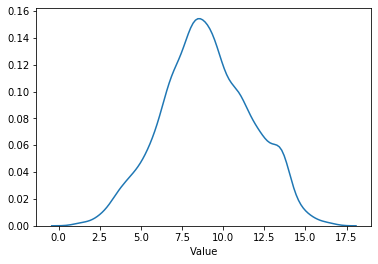

In [51]:
#looks better with log scale
_ = sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

The new distribution indeed looks better to train models on it.

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one **uniformized dataframe** `uni_df` with the following columns.


    Country | Year | GDP | Crops production columns | Livestock production columns | Crops importation columns | Livestock importation columns | Crops exportation columns | Livestock exportation columns | CPI
    
In this uniformized dataframe, **a tuple `(Country, Year)` uniquely identifies a row**.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

The current dataframes have several rows for a given `(Country, Year)`. Each of this row correspond to one item. We would like to have a unique row for a given `(Country, Year)` and one column per item:

In [52]:
need_pivot = ['Crops Production',
              'Livestock production',
              'Live animals import quantities',
              'Live animals export quantities',
              'Food import quantities',
              'Food export quantities']

def rename_columns(x, word):
    if x not in ['Area', 'Year', 'ha', 'tonnes', 'hg/ha', 'Head', '1000 Head']:
        return x + ' ' + word
    return x

df_useful['GDP'] = df_useful['GDP'].rename(columns = {'Value':'(GDP, million $)'})[["Area",'Year','(GDP, million $)']]
df_useful['Consumer price indices'] = df_useful['Consumer price indices'].rename(columns = {'Value':'(Consumer price indices, %)'})[["Area",'Year','(Consumer price indices, %)']]

for df_name in need_pivot :
    df_useful[df_name] = pd.pivot_table(df_useful[df_name], index=["Area",'Year'], columns=["Item","Unit"], values="Value").rename(columns=lambda x: rename_columns(x, df_name))
    display(df_name, df_useful[df_name].sample(5))

'Crops Production'

Item            Anise, badian, fennel, coriander Crops Production  \
Unit                                                       tonnes   
Area       Year                                                     
Cuba       1990                                               NaN   
Lebanon    1995                                              65.0   
Mauritania 1992                                               NaN   
Nauru      1984                                               NaN   
Cameroon   2014                                               NaN   

Item            Apples Crops Production Apricots Crops Production  \
Unit                             tonnes                    tonnes   
Area       Year                                                     
Cuba       1990                     NaN                       NaN   
Lebanon    1995                150600.0                   62000.0   
Mauritania 1992                     NaN                       NaN   
Nauru      1984                     NaN                       NaN   
Cameroon   2014                     NaN                     843.0   

Item            Areca nuts Crops Production Artichokes Crops Production  \
Unit                                 tonnes                      tonnes   
Area       Year                                                           
Cuba       1990                         NaN                         NaN   
Lebanon    1995                         NaN                      5900.0   
Mauritania 1992                         NaN                         NaN   
Nauru      1984                         NaN                         NaN   
Cameroon   2014                         NaN                         NaN   

Item            Asparagus Crops Production Avocados Crops Production  \
Unit                                tonnes                    tonnes   
Area       Year                                                        
Cuba       1990                        NaN                    9000.0   
Lebanon    1995                        NaN                       NaN   
Mauritania 1992                        NaN                       NaN   
Nauru      1984                        NaN                       NaN   
Cameroon   2014                        NaN                   66515.0   

Item            Bambara beans Crops Production Bananas Crops Production  \
Unit                                    tonnes                   tonnes   
Area       Year                                                           
Cuba       1990                            NaN                 195000.0   
Lebanon    1995                            NaN                  98500.0   
Mauritania 1992                            NaN                      NaN   
Nauru      1984                            NaN                      NaN   
Cameroon   2014                        38075.0                1719009.0   

Item            Barley Crops Production  ... Sweet potatoes Crops Production  \
Unit                             tonnes  ...                          tonnes   
Area       Year                          ...                                   
Cuba       1990                     NaN  ...                        195000.0   
Lebanon    1995                 33410.0  ...                             NaN   
Mauritania 1992                   400.0  ...                          2400.0   
Nauru      1984                     NaN  ...                             NaN   
Cameroon   2014                     NaN  ...                        362617.0   

Item            Tangerines, mandarins, clementines, satsumas Crops Production  \
Unit                                                                   tonnes   
Area       Year                                                                 
Cuba       1990                                            15000.0              
Lebanon    1995                                            23000.0              
Mauritania 1992                                                NaN   

'Livestock production'

Item             Animals live nes Livestock production  \
Unit                                              Head   
Area        Year                                         
Niger       1996                                   NaN   
Jamaica     1982                                   NaN   
India       1986                                   NaN   
Ethiopia    1977                                   NaN   
South Sudan 2004                                   NaN   

Item             Asses Livestock production Beehives Livestock production  \
Unit                                   Head       No Livestock production   
Area        Year                                                            
Niger       1996                  1235950.0                           NaN   
Jamaica     1982                    24500.0                       70000.0   
India       1986                  1000000.0                     9500000.0   
Ethiopia    1977                  3865000.0                     3167000.0   
South Sudan 2004                   750000.0                       74000.0   

Item             Buffaloes Livestock production  \
Unit                                       Head   
Area        Year                                  
Niger       1996                            NaN   
Jamaica     1982                            NaN   
India       1986                     77155008.0   
Ethiopia    1977                            NaN   
South Sudan 2004                            NaN   

Item             Camelids, other Livestock production  \
Unit                                             Head   
Area        Year                                        
Niger       1996                                  NaN   
Jamaica     1982                                  NaN   
India       1986                                  NaN   
Ethiopia    1977                                  NaN   
South Sudan 2004                                  NaN   

Item             Camels Livestock production Cattle Livestock production  \
Unit                                    Head                        Head   
Area        Year                                                           
Niger       1996                   1393620.0                   4342220.0   
Jamaica     1982                         NaN                    300000.0   
India       1986                   1014000.0                 197895008.0   
Ethiopia    1977                    950000.0                  25655008.0   
South Sudan 2004                   3724000.0                  39760000.0   

Item             Cattle and Buffaloes Livestock production  \
Unit                                                  Head   
Area        Year                                             
Niger       1996                                 4342220.0   
Jamaica     1982                                  300000.0   
India       1986                               275050016.0   
Ethiopia    1977                                25655008.0   
South Sudan 2004                                39760000.0   

Item             Chickens Livestock production Ducks Livestock production  \
Unit                                 1000 Head                  1000 Head   
Area        Year                                                            
Niger       1996                       10858.0                        NaN   
Jamaica     1982                        4500.0                        NaN   
India       1986                      260200.0                    22500.0   
Ethiopia    1977                       51800.0                        NaN   
South Sudan 2004                       37000.0                        NaN   

Item              ... Horses Livestock production Mules Livestock production  \
Unit              ...                        Head                       Head   
Area        Year  ...                                                          
Niger       1996  ...                    210270.0                        NaN   
Jamaica  

'Live animals import quantities'

Item               Animals live nes Live animals import quantities  \
Unit                                                          Head   
Area          Year                                                   
Finland       2006                                             NaN   
Samoa         1997                                             NaN   
Uzbekistan    1994                                             NaN   
Guinea-Bissau 1992                                             NaN   
Cyprus        1986                                             NaN   

Item               Asses Live animals import quantities  \
Unit                                               Head   
Area          Year                                        
Finland       2006                                  3.0   
Samoa         1997                                  NaN   
Uzbekistan    1994                                  NaN   
Guinea-Bissau 1992                                  0.0   
Cyprus        1986                                  NaN   

Item               Beehives Live animals import quantities  \
Unit                     No Live animals import quantities   
Area          Year                                           
Finland       2006                                     NaN   
Samoa         1997                                     NaN   
Uzbekistan    1994                                     NaN   
Guinea-Bissau 1992                                     NaN   
Cyprus        1986                                     NaN   

Item               Bovine, Animals Live animals import quantities  \
Unit                                                         Head   
Area          Year                                                  
Finland       2006                                          265.0   
Samoa         1997                                          220.0   
Uzbekistan    1994                                         1400.0   
Guinea-Bissau 1992                                            0.0   
Cyprus        1986                                            0.0   

Item               Buffaloes Live animals import quantities  \
Unit                                                   Head   
Area          Year                                            
Finland       2006                                      NaN   
Samoa         1997                                      NaN   
Uzbekistan    1994                                      NaN   
Guinea-Bissau 1992                                      NaN   
Cyprus        1986                                      NaN   

Item               Camelids, other Live animals import quantities  \
Unit                                                         Head   
Area          Year                                                  
Finland       2006                                            NaN   
Samoa         1997                                            NaN   
Uzbekistan    1994                                            NaN   
Guinea-Bissau 1992                                            NaN   
Cyprus        1986                                            NaN   

Item               Camels Live animals import quantities  \
Unit                                                Head   
Area          Year                                         
Finland       2006                                   NaN   
Samoa         1997                                   NaN   
Uzbekistan    1994                                   NaN   
Guinea-Bissau 1992                                   NaN   
Cyprus        1986                                   NaN   

Item               Cattle Live animals import quantities  \
Unit                                                Head   
Area          Year                                         
Finland       2006                                 265.0   
Samoa         1997                                 220.0   
Uzbekistan    1994                                1400.0   
Guinea-Bissau 199

'Live animals export quantities'

Item                             Animals live nes Live animals export quantities  \
Unit                                                                        Head   
Area                        Year                                                   
Republic of Moldova         1994                                             NaN   
United Republic of Tanzania 2011                                             0.0   
Croatia                     1992                                             NaN   
Estonia                     1966                                             NaN   
France                      1975                                             NaN   

Item                             Asses Live animals export quantities  \
Unit                                                             Head   
Area                        Year                                        
Republic of Moldova         1994                                  NaN   
United Republic of Tanzania 2011                                  0.0   
Croatia                     1992                                500.0   
Estonia                     1966                                  NaN   
France                      1975                                 31.0   

Item                             Beehives Live animals export quantities  \
Unit                                   No Live animals export quantities   
Area                        Year                                           
Republic of Moldova         1994                                     NaN   
United Republic of Tanzania 2011                                     NaN   
Croatia                     1992                                     NaN   
Estonia                     1966                                     NaN   
France                      1975                                     NaN   

Item                             Bovine, Animals Live animals export quantities  \
Unit                                                                       Head   
Area                        Year                                                  
Republic of Moldova         1994                                         7243.0   
United Republic of Tanzania 2011                                         2823.0   
Croatia                     1992                                        88000.0   
Estonia                     1966                                            NaN   
France                      1975                                      1354025.0   

Item                             Buffaloes Live animals export quantities  \
Unit                                                                 Head   
Area                        Year                                            
Republic of Moldova         1994                                      NaN   
United Republic of Tanzania 2011                                      NaN   
Croatia                     1992                                      NaN   
Estonia                     1966                                      NaN   
France                      1975                                      NaN   

Item                             Camelids, other Live animals export quantities  \
Unit                                                                       Head   
Area                        Year                                                  
Republic of Moldova         1994                                            NaN   
United Republic of Tanzania 2011                                            NaN   
Croatia                     1992                                            NaN   
Estonia                     1966                                            NaN   
France                      1975                                            NaN   

Item                             Camels Live animals export quantities  \
Unit                                                              Head   
Area                        Year      

'Food import quantities'

Item              Alfalfa meal and pellets Food import quantities  \
Unit                                                       tonnes   
Area         Year                                                   
Saudi Arabia 1962                                             0.0   
Norway       1987                                          1665.0   
Burkina Faso 1992                                             NaN   
Romania      2013                                          5377.0   
Kazakhstan   1990                                             NaN   

Item              Almonds shelled Food import quantities  \
Unit                                              tonnes   
Area         Year                                          
Saudi Arabia 1962                                    0.0   
Norway       1987                                 3520.0   
Burkina Faso 1992                                    NaN   
Romania      2013                                  737.0   
Kazakhstan   1990                                 5081.0   

Item              Animal Oil+Fat+Grs Food import quantities  \
Unit                                                 tonnes   
Area         Year                                             
Saudi Arabia 1962                                       0.0   
Norway       1987                                    5878.0   
Burkina Faso 1992                                       NaN   
Romania      2013                                   15727.0   
Kazakhstan   1990                                   59986.0   

Item              Animal Vegetable Oil Food import quantities  \
Unit                                                   tonnes   
Area         Year                                               
Saudi Arabia 1962                                      3427.0   
Norway       1987                                     22786.0   
Burkina Faso 1992                                      6153.0   
Romania      2013                                    178348.0   
Kazakhstan   1990                                    849436.0   

Item              Animal fats Food import quantities  \
Unit                                          tonnes   
Area         Year                                      
Saudi Arabia 1962                                0.0   
Norway       1987                             5878.0   
Burkina Faso 1992                                NaN   
Romania      2013                            15727.0   
Kazakhstan   1990                            59986.0   

Item              Anise, badian, fennel, coriander Food import quantities  \
Unit                                                               tonnes   
Area         Year                                                           
Saudi Arabia 1962                                                0.0        
Norway       1987                                              182.0        
Burkina Faso 1992                                                NaN        
Romania      2013                                              516.0        
Kazakhstan   1990                                              220.0        

Item              Apples Food import quantities  \
Unit                                     tonnes   
Area         Year                                 
Saudi Arabia 1962                        5910.0   
Norway       1987                       44947.0   
Burkina Faso 1992                           0.0   
Romania      2013                       62785.0   
Kazakhstan   1990                      337541.0   

Item              Apricots Food import quantities  \
Unit                                       tonnes   
Area         Year                                   
Saudi Arabia 1962                             0.0   
Norway       1987                            14.0   
Burkina Faso 1992                             NaN   
Romania      2013                          2751.0   
Kazakhstan   1990                           218.0   

Item              Apricots, dry Food imp

'Food export quantities'

Item          Alfalfa meal and pellets Food export quantities  \
Unit                                                   tonnes   
Area     Year                                                   
Kiribati 1974                                             NaN   
Armenia  1977                                             NaN   
Nigeria  1997                                             NaN   
Finland  1987                                             NaN   
Slovakia 1976                                             NaN   

Item          Almonds shelled Food export quantities  \
Unit                                          tonnes   
Area     Year                                          
Kiribati 1974                                    NaN   
Armenia  1977                                    0.0   
Nigeria  1997                                    NaN   
Finland  1987                                    0.0   
Slovakia 1976                                    NaN   

Item          Animal Oil+Fat+Grs Food export quantities  \
Unit                                             tonnes   
Area     Year                                             
Kiribati 1974                                       NaN   
Armenia  1977                                    4000.0   
Nigeria  1997                                       NaN   
Finland  1987                                    2567.0   
Slovakia 1976                                       0.0   

Item          Animal Vegetable Oil Food export quantities  \
Unit                                               tonnes   
Area     Year                                               
Kiribati 1974                                         NaN   
Armenia  1977                                    236225.0   
Nigeria  1997                                     65511.0   
Finland  1987                                     56080.0   
Slovakia 1976                                      1419.0   

Item          Animal fats Food export quantities  \
Unit                                      tonnes   
Area     Year                                      
Kiribati 1974                                NaN   
Armenia  1977                             4000.0   
Nigeria  1997                                NaN   
Finland  1987                             2567.0   
Slovakia 1976                                0.0   

Item          Anise, badian, fennel, coriander Food export quantities  \
Unit                                                           tonnes   
Area     Year                                                           
Kiribati 1974                                                NaN        
Armenia  1977                                                NaN        
Nigeria  1997                                                NaN        
Finland  1987                                               28.0        
Slovakia 1976                                                NaN        

Item          Apples Food export quantities Apricots Food export quantities  \
Unit                                 tonnes                          tonnes   
Area     Year                                                                 
Kiribati 1974                           NaN                             NaN   
Armenia  1977                           NaN                             NaN   
Nigeria  1997                           NaN                             NaN   
Finland  1987                           0.0                             0.0   
Slovakia 1976                        9929.0                             NaN   

Item          Apricots, dry Food export quantities  \
Unit                                        tonnes   
Area     Year                                        
Kiribati 1974                                  NaN   
Armenia  1977                                  NaN   
Nigeria  1997                                  NaN   
Finland  1987                                 14.0   
Slovakia 1976                                  NaN   



Some **Nan values** have appeared. After some analysis, we have conclude to replace those Nan values by zeros. Indeed, it seems that those Nan values means that the value were very low and not significant to be measured.

In [53]:
# Deal with the NaN that appeared
for df_name in df_useful :
    if df_name != "GDP":
        for column in list(df_useful[df_name]):
            if column not in ['Area', 'Year']:
                df_useful[df_name][column].fillna(0, inplace=True)

In [54]:
#removing the multiindex, so that merge is clean with GDP and CPI
for df_name in need_pivot :
    df_useful[df_name].columns = [' '.join([str(_) for _ in v]) for v in df_useful[df_name].columns.values]
    display(df_useful[df_name].sample(5))
    

Anise, badian, fennel, coriander Crops Production tonnes  \
Area    Year                                                             
Iran    1968                                            11300.0          
Egypt   1999                                            22000.0          
Bahamas 2013                                                0.0          
Jamaica 1963                                                0.0          
Denmark 2006                                               50.0          

              Apples Crops Production tonnes  \
Area    Year                                   
Iran    1968                         80000.0   
Egypt   1999                        415647.0   
Bahamas 2013                             0.0   
Jamaica 1963                             0.0   
Denmark 2006                         31779.0   

              Apricots Crops Production tonnes  \
Area    Year                                     
Iran    1968                           50000.0   
Egypt   1999                           43042.0   
Bahamas 2013                               0.0   
Jamaica 1963                               0.0   
Denmark 2006                               0.0   

              Areca nuts Crops Production tonnes  \
Area    Year                                       
Iran    1968                                 0.0   
Egypt   1999                                 0.0   
Bahamas 2013                                 0.0   
Jamaica 1963                                 0.0   
Denmark 2006                                 0.0   

              Artichokes Crops Production tonnes  \
Area    Year                                       
Iran    1968                                 0.0   
Egypt   1999                             43769.0   
Bahamas 2013                                 0.0   
Jamaica 1963                                 0.0   
Denmark 2006                                 0.0   

              Asparagus Crops Production tonnes  \
Area    Year                                      
Iran    1968                                0.0   
Egypt   1999                                0.0   
Bahamas 2013                                0.0   
Jamaica 1963                                0.0   
Denmark 2006                               62.0   

              Avocados Crops Production tonnes  \
Area    Year                                     
Iran    1968                               0.0   
Egypt   1999                               0.0   
Bahamas 2013                            1267.0   
Jamaica 1963                            2315.0   
Denmark 2006                               0.0   

              Bambara beans Crops Production tonnes  \
Area    Year                                          
Iran    1968                                    0.0   
Egypt   1999                                    0.0   
Bahamas 2013                                    0.0   
Jamaica 1963                                    0.0   
Denmark 2006                                    0.0   

              Bananas Crops Production tonnes  Barley Crops Production tonnes  \
Area    Year                                                                    
Iran    1968                              0.0                       1160000.0   
Egypt   1999                         728999.0                        114359.0   
Bahamas 2013                           9507.0                             0.0   
Jamaica 1963                         199300.0                             0.0   
Denmark 2006                              0.0                       3270300.0   

              ...  Sweet potatoes Crops Production tonnes  \
Area    Year  ...                                           
Iran    1968  ...                                     0.0   
Egypt   1999  ...                                253053.0   
Bahamas 2013  ...                                  1666.0   
Jamaica 1963  ...                                 10886.0   
Denmark 2006  ...                               

Animals live nes Livestock production Head  \
Area        Year                                               
Comoros     1995                                         0.0   
Guyana      1996                                         0.0   
Ivory Coast 2008                                         0.0   
Djibouti    1988                                         0.0   
Thailand    1961                                         0.0   

                  Asses Livestock production Head  \
Area        Year                                    
Comoros     1995                           4900.0   
Guyana      1996                           1000.0   
Ivory Coast 2008                              0.0   
Djibouti    1988                           7800.0   
Thailand    1961                            216.0   

                  Beehives Livestock production No Livestock production  \
Area        Year                                                          
Comoros     1995                                                0.0       
Guyana      1996                                             4100.0       
Ivory Coast 2008                                                0.0       
Djibouti    1988                                                0.0       
Thailand    1961                                                0.0       

                  Buffaloes Livestock production Head  \
Area        Year                                        
Comoros     1995                                  0.0   
Guyana      1996                                  0.0   
Ivory Coast 2008                                  0.0   
Djibouti    1988                                  0.0   
Thailand    1961                            4963580.0   

                  Camelids, other Livestock production Head  \
Area        Year                                              
Comoros     1995                                        0.0   
Guyana      1996                                        0.0   
Ivory Coast 2008                                        0.0   
Djibouti    1988                                        0.0   
Thailand    1961                                        0.0   

                  Camels Livestock production Head  \
Area        Year                                     
Comoros     1995                               0.0   
Guyana      1996                               0.0   
Ivory Coast 2008                               0.0   
Djibouti    1988                           58000.0   
Thailand    1961                               0.0   

                  Cattle Livestock production Head  \
Area        Year                                     
Comoros     1995                           45700.0   
Guyana      1996                          160000.0   
Ivory Coast 2008                         1537748.0   
Djibouti    1988                          160000.0   
Thailand    1961                         3542420.0   

                  Cattle and Buffaloes Livestock production Head  \
Area        Year                                                   
Comoros     1995                                         45700.0   
Guyana      1996                                        160000.0   
Ivory Coast 2008                                       1537748.0   
Djibouti    1988                                        160000.0   
Thailand    1961                                       8506000.0   

                  Chickens Livestock production 1000 Head  \
Area        Year                                            
Comoros     1995                                    440.0   
Guyana      1996                                   9000.0   
Ivory Coast 2008                                  40674.0   
Djibouti    1988                                      0.0   
Thailand    1961                                  39377.0   

                  Ducks Livestock production 1000 Head  ...  \
Area        Year                                        ...   
Comoros     1995                        

Animals live nes Live animals import quantities Head  \
Area       Year                                                         
Niue       2000                                                0.0      
Slovakia   2004                                                0.0      
Togo       1961                                                0.0      
Tonga      1997                                                0.0      
Luxembourg 2013                                                0.0      

                 Asses Live animals import quantities Head  \
Area       Year                                              
Niue       2000                                        0.0   
Slovakia   2004                                        0.0   
Togo       1961                                        0.0   
Tonga      1997                                        0.0   
Luxembourg 2013                                        0.0   

                 Beehives Live animals import quantities No Live animals import quantities  \
Area       Year                                                                              
Niue       2000                                                0.0                           
Slovakia   2004                                                0.0                           
Togo       1961                                                0.0                           
Tonga      1997                                                0.0                           
Luxembourg 2013                                                0.0                           

                 Bovine, Animals Live animals import quantities Head  \
Area       Year                                                        
Niue       2000                                                0.0     
Slovakia   2004                                              332.0     
Togo       1961                                             8154.0     
Tonga      1997                                              508.0     
Luxembourg 2013                                             4906.0     

                 Buffaloes Live animals import quantities Head  \
Area       Year                                                  
Niue       2000                                            0.0   
Slovakia   2004                                            0.0   
Togo       1961                                            0.0   
Tonga      1997                                            0.0   
Luxembourg 2013                                            8.0   

                 Camelids, other Live animals import quantities Head  \
Area       Year                                                        
Niue       2000                                                0.0     
Slovakia   2004                                                0.0     
Togo       1961                                                0.0     
Tonga      1997                                                0.0     
Luxembourg 2013                                                0.0     

                 Camels Live animals import quantities Head  \
Area       Year                                               
Niue       2000                                         0.0   
Slovakia   2004                                         0.0   
Togo       1961                                         0.0   
Tonga      1997                                         0.0   
Luxembourg 2013                                         9.0   

                 Cattle Live animals import quantities Head  \
Area       Year                                               
Niue       2000                                         0.0   
Slovakia   2004                                       332.0   
Togo       1961                                      8154.0   
Tonga      1997                                       508.0   
Luxembourg 2013                                      4898.0   

                 Chickens Live animals import quantiti

Animals live nes Live animals export quantities Head  \
Area                     Year                                                         
Denmark                  1977                                                0.0      
Cabo Verde               1971                                                0.0      
Central African Republic 1980                                                0.0      
Egypt                    2002                                                0.0      
Bulgaria                 2006                                                0.0      

                               Asses Live animals export quantities Head  \
Area                     Year                                              
Denmark                  1977                                        0.0   
Cabo Verde               1971                                        0.0   
Central African Republic 1980                                        0.0   
Egypt                    2002                                        0.0   
Bulgaria                 2006                                     1187.0   

                               Beehives Live animals export quantities No Live animals export quantities  \
Area                     Year                                                                              
Denmark                  1977                                                0.0                           
Cabo Verde               1971                                                0.0                           
Central African Republic 1980                                                0.0                           
Egypt                    2002                                              498.0                           
Bulgaria                 2006                                                0.0                           

                               Bovine, Animals Live animals export quantities Head  \
Area                     Year                                                        
Denmark                  1977                                            17848.0     
Cabo Verde               1971                                             1000.0     
Central African Republic 1980                                             4100.0     
Egypt                    2002                                                0.0     
Bulgaria                 2006                                            70143.0     

                               Buffaloes Live animals export quantities Head  \
Area                     Year                                                  
Denmark                  1977                                            0.0   
Cabo Verde               1971                                            0.0   
Central African Republic 1980                                            0.0   
Egypt                    2002                                            0.0   
Bulgaria                 2006                                            0.0   

                               Camelids, other Live animals export quantities Head  \
Area                     Year                                                        
Denmark                  1977                                                0.0     
Cabo Verde               1971                                                0.0     
Central African Republic 1980                                                0.0     
Egypt                    2002                                                0.0     
Bulgaria                 2006                                                0.0     

                               Camels Live animals export quantities Head  \
Area                     Year                                               
Denmark                  1977                                         0.0   
Cabo Verde               1971                                         0.0   
Central African Republic 1980                           

Alfalfa meal and pellets Food import quantities tonnes  \
Area          Year                                                           
Sudan         2000                                                0.0        
New Caledonia 2001                                               91.0        
Italy         1971                                            25543.0        
Namibia       1985                                                0.0        
Malawi        1997                                                0.0        

                    Almonds shelled Food import quantities tonnes  \
Area          Year                                                  
Sudan         2000                                            0.0   
New Caledonia 2001                                           26.0   
Italy         1971                                         1610.0   
Namibia       1985                                            0.0   
Malawi        1997                                            0.0   

                    Animal Oil+Fat+Grs Food import quantities tonnes  \
Area          Year                                                     
Sudan         2000                                           91950.0   
New Caledonia 2001                                              35.0   
Italy         1971                                           55670.0   
Namibia       1985                                               0.0   
Malawi        1997                                              10.0   

                    Animal Vegetable Oil Food import quantities tonnes  \
Area          Year                                                       
Sudan         2000                                           111462.0    
New Caledonia 2001                                             2640.0    
Italy         1971                                           461001.0    
Namibia       1985                                                0.0    
Malawi        1997                                            17300.0    

                    Animal fats Food import quantities tonnes  \
Area          Year                                              
Sudan         2000                                    91950.0   
New Caledonia 2001                                       35.0   
Italy         1971                                    55670.0   
Namibia       1985                                        0.0   
Malawi        1997                                       10.0   

                    Anise, badian, fennel, coriander Food import quantities tonnes  \
Area          Year                                                                   
Sudan         2000                                              161.0                
New Caledonia 2001                                                5.0                
Italy         1971                                              640.0                
Namibia       1985                                                0.0                
Malawi        1997                                                0.0                

                    Apples Food import quantities tonnes  \
Area          Year                                         
Sudan         2000                                  67.0   
New Caledonia 2001                                1288.0   
Italy         1971                               25256.0   
Namibia       1985                                   0.0   
Malawi        1997                                 335.0   

                    Apricots Food import quantities tonnes  \
Area          Year                                           
Sudan         2000                                     1.0   
New Caledonia 2001                                     6.0   
Italy         1971                                  6236.0   
Namibia       1985                                     0.0   
Malawi        1997                                     1.0   

                    Apricots, dry Food import quan

Alfalfa meal and pellets Food export quantities tonnes  \
Area                             Year                                                           
Saint Vincent and the Grenadines 1986                                                0.0        
Haiti                            1965                                                0.0        
Argentina                        1980                                                0.0        
Pakistan                         1997                                                0.0        
Cuba                             1970                                                0.0        

                                       Almonds shelled Food export quantities tonnes  \
Area                             Year                                                  
Saint Vincent and the Grenadines 1986                                            0.0   
Haiti                            1965                                            0.0   
Argentina                        1980                                            0.0   
Pakistan                         1997                                          219.0   
Cuba                             1970                                            0.0   

                                       Animal Oil+Fat+Grs Food export quantities tonnes  \
Area                             Year                                                     
Saint Vincent and the Grenadines 1986                                               0.0   
Haiti                            1965                                               0.0   
Argentina                        1980                                           60782.0   
Pakistan                         1997                                               0.0   
Cuba                             1970                                               0.0   

                                       Animal Vegetable Oil Food export quantities tonnes  \
Area                             Year                                                       
Saint Vincent and the Grenadines 1986                                              161.0    
Haiti                            1965                                               37.0    
Argentina                        1980                                           857271.0    
Pakistan                         1997                                                0.0    
Cuba                             1970                                                0.0    

                                       Animal fats Food export quantities tonnes  \
Area                             Year                                              
Saint Vincent and the Grenadines 1986                                        0.0   
Haiti                            1965                                        0.0   
Argentina                        1980                                    60782.0   
Pakistan                         1997                                        0.0   
Cuba                             1970                                        0.0   

                                       Anise, badian, fennel, coriander Food export quantities tonnes  \
Area                             Year                                                                   
Saint Vincent and the Grenadines 1986                                                0.0                
Haiti                            1965                                                0.0                
Argentina                        1980                                              636.0                
Pakistan                         1997                                             2460.0                
Cuba                             1970                                                0.0                

                                       Apples Food export quantities tonnes  \
Area                             Year           

#### 1.F.b. Dealing with unit discrepencies  <a name="1Fb"></a>
Before merging dataframes, we notice two different units in the dataframes dealing with livestock datas: "1000 Heads" and "Heads". Let's have a look at the following dataframes:
* Livestock production
* Live animals import quantities
* Live animals export quantities


In [55]:
#Select dfs that correspond to livestock data
livestock_dfs={s:df_useful[s] for s in df_useful.keys() if 'live' in s.lower()}

Before handling the data, we want to know if the columns presented in "1000 Heads" are also presented in "Heads"

In [56]:
# Useful method to remove words from string
def drop_words( s , w=1 , end=True):
    if end:
        return s.rsplit(' ',w)[0]
    else:
        return s.split(' ',w)[-1]
    

for key in livestock_dfs.keys():
    col=livestock_dfs[key].columns
    th_heads=[s for s in col if '1000 head' in s.lower()]
    heads=[s for s in col if '1000 head' not in s.lower()]
    shared=[s for s in th_heads if drop_words(s,2)+" Head" in heads]
    print('There are {} columns expressed in "1000 Heads" and {} columns expressed in "Head" in the dataframe {} and {} columns are expressed in both'
          .format(len(th_heads),len(heads),key,len(shared)))
    

There are 8 columns expressed in "1000 Heads" and 14 columns expressed in "Head" in the dataframe Livestock production and 0 columns are expressed in both
There are 6 columns expressed in "1000 Heads" and 14 columns expressed in "Head" in the dataframe Live animals import quantities and 0 columns are expressed in both
There are 6 columns expressed in "1000 Heads" and 14 columns expressed in "Head" in the dataframe Live animals export quantities and 0 columns are expressed in both


In [57]:
def convert_1000H_to_head(df):
    
    # methods converting the columns expressed in "1000 Head" in "Head" and renaming them
    
    cols_to_convert=[col for col in df.columns if '1000 head' in col.lower()]
    df[cols_to_convert]=df[cols_to_convert]*1000
    new_cols=[drop_words(s,2)+' Head' for s in cols_to_convert]
    name_dic={old:new for old,new in zip(cols_to_convert,new_cols)}
    df=df.rename(columns=name_dic)
    return df

In [58]:
for key in livestock_dfs.keys():
    df_useful[key]=convert_1000H_to_head(df_useful[key])
    display(df_useful[key].head(1))

Animals live nes Livestock production Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Asses Livestock production Head  \
Area        Year                                    
Afghanistan 1961                        1300000.0   

                  Beehives Livestock production No Livestock production  \
Area        Year                                                          
Afghanistan 1961                                                0.0       

                  Buffaloes Livestock production Head  \
Area        Year                                        
Afghanistan 1961                                  0.0   

                  Camelids, other Livestock production Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Camels Livestock production Head  \
Area        Year                                     
Afghanistan 1961                          250000.0   

                  Cattle Livestock production Head  \
Area        Year                                     
Afghanistan 1961                         2900000.0   

                  Cattle and Buffaloes Livestock production Head  \
Area        Year                                                   
Afghanistan 1961                                       2900000.0   

                  Chickens Livestock production Head  \
Area        Year                                       
Afghanistan 1961                           4700000.0   

                  Ducks Livestock production Head  ...  \
Area        Year                                   ...   
Afghanistan 1961                              0.0  ...   

                  Horses Livestock production Head  \
Area        Year                                     
Afghanistan 1961                          276841.0   

                  Mules Livestock production Head  \
Area        Year                                    
Afghanistan 1961                          20000.0   

                  Pigeons, other birds Livestock production Head  \
Area        Year                                                   
Afghanistan 1961                                             0.0   

                  Pigs Livestock production Head  \
Area        Year                                   
Afghanistan 1961                             0.0   

                  Poultry Birds Livestock production Head  \
Area        Year                                            
Afghanistan 1961                                4700000.0   

                  Rabbits and hares Livestock production Head  \
Area        Year                                                
Afghanistan 1961                                          0.0   

                  Rodents, other Livestock production Head  \
Area        Year                                             
Afghanistan 1961                                       0.0   

                  Sheep Livestock production Head  \
Area        Year                                    
Afghanistan 1961                       18000000.0   

                  Sheep and Goats Livestock production Head  \
Area        Year                                              
Afghanistan 1961                                 22200000.0   

                  Turkeys Livestock production Head  
Area        Year                                     
Afghanistan 1961                                0.0  

[1 rows x 22 columns]

Animals live nes Live animals import quantities Head  \
Area        Year                                                         
Afghanistan 1961                                                0.0      

                  Asses Live animals import quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Beehives Live animals import quantities No Live animals import quantities  \
Area        Year                                                                              
Afghanistan 1961                                                0.0                           

                  Bovine, Animals Live animals import quantities Head  \
Area        Year                                                        
Afghanistan 1961                                                0.0     

                  Buffaloes Live animals import quantities Head  \
Area        Year                                                  
Afghanistan 1961                                            0.0   

                  Camelids, other Live animals import quantities Head  \
Area        Year                                                        
Afghanistan 1961                                                0.0     

                  Camels Live animals import quantities Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Cattle Live animals import quantities Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Chickens Live animals import quantities Head  \
Area        Year                                                 
Afghanistan 1961                                           0.0   

                  Ducks Live animals import quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Goats Live animals import quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Horses Live animals import quantities Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Mules Live animals import quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Pigeons, other birds Live animals import quantities Head  \
Area        Year                                                             
Afghanistan 1961                                                0.0          

                  Pigs Live animals import quantities Head  \
Area        Year                                             
Afghanistan 1961                                       0.0   

                  Rabbits and hares Live animals import quantities Head  \
Area        Year                                                          
Afghanistan 1961                                                0.0       

                  Rodents, other Live animals import quantities Head  \
Area        Year                                                       
Afghanistan 1961                                                0.0    

                  Sheep Live animals import quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Sheep and Goats Live animals import quantities Head  \
Area        Year                                                        
Afghanistan 1961                                                0.0     

                  Turkeys Live animals import quantiti

Animals live nes Live animals export quantities Head  \
Area        Year                                                         
Afghanistan 1961                                                0.0      

                  Asses Live animals export quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Beehives Live animals export quantities No Live animals export quantities  \
Area        Year                                                                              
Afghanistan 1961                                                0.0                           

                  Bovine, Animals Live animals export quantities Head  \
Area        Year                                                        
Afghanistan 1961                                                0.0     

                  Buffaloes Live animals export quantities Head  \
Area        Year                                                  
Afghanistan 1961                                            0.0   

                  Camelids, other Live animals export quantities Head  \
Area        Year                                                        
Afghanistan 1961                                                0.0     

                  Camels Live animals export quantities Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Cattle Live animals export quantities Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Chickens Live animals export quantities Head  \
Area        Year                                                 
Afghanistan 1961                                           0.0   

                  Ducks Live animals export quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Goats Live animals export quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Horses Live animals export quantities Head  \
Area        Year                                               
Afghanistan 1961                                         0.0   

                  Mules Live animals export quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Pigeons, other birds Live animals export quantities Head  \
Area        Year                                                             
Afghanistan 1961                                                0.0          

                  Pigs Live animals export quantities Head  \
Area        Year                                             
Afghanistan 1961                                       0.0   

                  Rabbits and hares Live animals export quantities Head  \
Area        Year                                                          
Afghanistan 1961                                                0.0       

                  Rodents, other Live animals export quantities Head  \
Area        Year                                                       
Afghanistan 1961                                                0.0    

                  Sheep Live animals export quantities Head  \
Area        Year                                              
Afghanistan 1961                                        0.0   

                  Sheep and Goats Live animals export quantities Head  \
Area        Year                                                        
Afghanistan 1961                                                0.0     

                  Turkeys Live animals export quantiti

#### 1.F.c. Merging everything  <a name="1Fc"></a>
We are now creating the uniformized dataframe `uni_df`. Each row corresponds to one tuple `(Country, Year)` so that we can later **group by country** or **year**. In addition to the country ("Area") and the "Year", the columns will either be an **economic feature ("GDP", "CPI")** or an **agricultural one (some crop harvested area, some livestock export quantity, ...)**. With this uniformized dataframe, we can later on **analyze correlations and links** between different feautures place and yearwise. This means we can measure a correlation of e.g. GDP with the production of a specific crop over all countries and all years.

In [59]:
uni_df = df_useful['GDP'].dropna()
for df_name in need_pivot :
    uni_df = pd.merge(uni_df, df_useful[df_name], how='left', on=['Area', 'Year'])
uni_df = pd.merge(uni_df,df_useful['Consumer price indices'], how='left', on=['Area', 'Year'])

# Deal with the NaN that appeared
for column in list(uni_df):
    if column not in ['Area', 'Year']:
        uni_df[column].fillna(0, inplace=True)
uni_df.sample(30)

Area  Year  (GDP, million $)  \
3042                    Finland  2003      1.710645e+05   
200                      Angola  1986      8.548514e+03   
5077                   Maldives  2005      1.119807e+03   
6131                  Nicaragua  2011      9.755633e+03   
2006      Republic of the Congo  1981      1.993534e+03   
4159                      Italy  1990      1.177387e+06   
3253                    Georgia  2004      5.125766e+03   
2133                Ivory Coast  1970      1.500931e+03   
1517                   Cameroon  2003      1.362174e+04   
4596                     Latvia  2010      2.376514e+04   
3295                    Germany  2000      1.949952e+06   
4679                    Lesotho  2001      7.063936e+02   
6190                    Nigeria  1978      1.264498e+05   
1861                      China  1979      2.622637e+05   
7482                 Seychelles  1996      6.034477e+02   
6618                       Peru  1992      3.588425e+04   
5907  Sint Maarten (Dutch Part)  1975      4.679230e+02   
1351                    Burundi  1975      4.139079e+02   
6632                       Peru  2006      8.865856e+04   
6820                Puerto Rico  2010      9.838130e+04   
5242                 Mauritania  1986      1.275103e+03   
1862                      China  1980      3.053457e+05   
575                     Bahamas  1987      2.811080e+03   
7006                     Russia  2006      9.899321e+05   
3498                  Guatemala  1973      2.290471e+03   
6056                New Zealand  1982      2.508314e+04   
8400                      Tonga  1980      7.888835e+01   
1397                 Cabo Verde  1975      1.339654e+02   
6838                      Qatar  1982      7.611264e+03   
8132                Switzerland  1974      5.531127e+04   

      Anise, badian, fennel, coriander Crops Production tonnes  \
3042                                                0.0          
200                                                 0.0          
5077                                                0.0          
6131                                                0.0          
2006                                                0.0          
4159                                                0.0          
3253                                               30.0          
2133                                                0.0          
1517                                                0.0          
4596                                                0.0          
3295                                                0.0          
4679                                                0.0          
6190                                                0.0          
1861                                             9000.0          
7482                                                0.0          
6618                                                0.0          
5907                                                0.0          
1351                                                0.0          
6632                                             7200.0          
6820                                                0.0          
5242                                                0.0          
1862                                            10000.0          
575                                                 0.0          
7006                                             4190.0          
3498                                              150.0          
6056                                                0.0          
8400                                                0.0          
1397                                                0.0          
6838                                                0.0          
8132                                                0.0          

      Apples Crops Production tonnes  Apricots Crops Production tonnes  \
3042                          2834.0                               0.0   
20

#### 1.G The last filter  <a name="1G"></a>

At the very beginning, when importing data for the crops production, we focused on the "food crops". It is very likely that the import and export dataframes contain more data than we have in the production dataframe. As we want, later, compare these data, we decide to keep only the crops and animals for which we have production,import and export data.  

Let's have a look!

In [60]:
import_cols=[col for col in uni_df.columns if 'import' in col.lower()]
export_cols=[col for col in uni_df.columns if 'export' in col.lower()]
prod_cols=[col for col in uni_df.columns if 'production' in col.lower()]
others=[col for col in uni_df.columns if 'production' not in col.lower() and 'export' not in col.lower() and 'import' not in col.lower()]
print('There are {} import columns, {} export columns,{} production columns and {} other.'.format(len(import_cols),len(export_cols),len(prod_cols),len(others)))

There are 472 import columns, 464 export columns,144 production columns and 4 other.


There is indeed much work to be done!

In [61]:
import_col_dic={drop_words(s,3):s for s in import_cols}
export_col_dic={drop_words(s,3):s for s in export_cols}
prod_col_dic={drop_words(s,3):s for s in prod_cols}

import_keys=list(import_col_dic.keys())
export_keys=list(export_col_dic.keys())
prod_keys=list(prod_col_dic.keys())

prod=set([])
imp=set([])
exp=set([])

for prod_feature in prod_keys:
    for imp_feature in import_keys:
        if prod_feature.lower()+" food" == imp_feature.lower() or prod_feature.lower()+" live animals" == imp_feature.lower():
            for exp_feature in export_keys:
                if prod_feature.lower()+" food" == exp_feature.lower() or prod_feature.lower()+" live animals" == exp_feature.lower():
                    prod.add(prod_feature)
                    imp.add(imp_feature)
                    exp.add(exp_feature)
prod=list(prod)
prod.sort()
exp=list(exp)
exp.sort()
imp=list(imp)
imp.sort()

print('We find {} columns present in import, export and production'.format(len(prod)))

import_cols=[import_col_dic[k] for k in imp]
export_cols=[export_col_dic[k] for k in exp]
prod_cols=[prod_col_dic[k] for k in prod]

cols_of_interest=others+import_cols+export_cols+prod_cols

We find 107 columns present in import, export and production


In [62]:
uni_df=uni_df[cols_of_interest]

In [63]:
import pickle
pickle.dump(uni_df,open("Scripts/Data/uni_df.pkl",'wb'))

### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)      
                
    3. [Structure of international trade and historical context](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Consumer price indices](#2B), then study the [structure of international trade and historical context](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)

##### 2.A.a Crops and livestock production and trade <a name="2Aa"></a>
For the next milestone, we will also produce some maps, showing for instance the production of a specific crop per country over the years. We have shown in previous parts that the dataset contains the necessary data and that we can handle the data in its size and plot maps.

##### 2.A.b Introducing the concept of food self-sufficiency <a name="2Ab"></a>
In this section we will present and compute the **notion of food self-sufficiency**. We will use the **quantitative definition of the Food and Agriculture Organization (FAO)**. 
###### 2.A.b.i Basic idea <a name="2Abi"></a>
One may wonder how to know **whether a country produces all the food it needs or not**. The notion of food-self-sufficency allows to answer to this question. More formally, it is a rate that decribes how **to which degree a country can satisfy to meet its internal consumption needs by production**. It describes the extent to which a country is able to **feed its population through its domestic food production**. We are interested in this measure since we think**it could be correlated** with the economic conditions of this country, particularly **price stability**. Price stability is defined in the next part.
###### 2.A.b.ii Formula and computation <a name="2Abii"></a>
In order to compute the food self-sufficiency, we will apply the following **formula** that gives us the **food self-sudfficiency as a percentage** :

$$\frac{Production \times 100}{Production + Imports – Exports}$$

The following is a trial calculation of self-sufficiency. Refining which agriculutral products should go into this calculation still need to be done for next milestone. Indeed with our first calculations it seems that the self-sufficiency is always lower than 100% whereas this should not be the case.

In [64]:
def compute_self_suficiency(df,w=None, weighing=False):
    
    
    # From the unified dataframe df, compute the self sufficiency score for each year for each country
    # if a paramter of weights is given as a dict, the method returns the aggregated score.
    
    weights=w.copy()
    
    #Useful method to manipulate names
    def drop_words( s , w=1 , end=True):
        if end:
            return s.rsplit(' ',w)[0]
        else:
            return s.split(' ',w)[-1]
    
    df=df.set_index(['Area','Year'])
    
    #Getting the columns corresponding to import, export and production
    import_cols=[col for col in df.columns if 'import' in col.lower()]
    export_cols=[col for col in df.columns if 'export' in col.lower()]
    prod_cols=[col for col in df.columns if 'production' in col.lower()]
    
    #Initializing new dataframe
    scores=pd.DataFrame(index=df.index)
    
    #Generating scores
    for i,col in enumerate(import_cols):
        scores[drop_words(col,3)]=(df[prod_cols[i]]*100/(
                                    df[prod_cols[i]]+df[import_cols[i]]-df[export_cols[i]]))
    
    #If no weights, return scores without aggregate
    if weights==None:
        return scores
    
    features=[w for w in weights.keys()]
    temp=pd.DataFrame(index=df.index)
    
    #replacing na with 0 to avoid na aggregated scores
    scores=scores.fillna(0)
    
    #Selecting features of interest and multiplying them with their weight
    #Note: Some weights refer to the same score (eg 'Maize Crops Production tonnes' and 'Maize Food import quantities tonnes') to go around this problem, the scores referring to the same columns are sumed
    
    temp_dic={}#Will retain data untill complete and then turned into pandas DataFrame
    popped=[] #Will store the weights that are already taken care of because they reffered to the same columns as another weight already treated
    for feat in list(weights.keys()):
        if feat not in popped:
            w_agg={feat:weights[feat]}
            s=re.split(' Food| Live.*| Crops',feat)[0]
            s='^'+s
            w=weights[feat]

            for f in list(weights.keys()):
                if f!=feat and re.search(s,f) and s[1:]==re.split(' Food.*| Live.*| Crops.*',f)[0]:
                    w+=weights[f]
                    w_agg.update({f:weights[f]})
                    popped.append(f)
            cols=[c for c in scores.columns if re.split(' Food.*| Live.*| Crops.*',c)[0]==s[1:]]
            if len(cols)==0:
                print('\n {} NOT FOUND'.format(feat))
            else:
                #print('{} weight : {} agg from: {}'.format(feat,w,w_agg))
                temp_df=scores[cols].copy()
                if weighing:
                    temp_df=temp_df.apply(lambda x: x*w)
                else:
                    temp_df=temp_df.apply(lambda x: x*1/len(features))
                temp_dic.update(temp_df.to_dict())
            
    temp=pd.DataFrame(temp_dic)
    #Aggregating the scores
    scores=pd.DataFrame(temp.sum(axis=1),columns=['Agg'])
    
    
    return scores

#### 2.B. Consumer price indices  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Definition](#2Ba) 
    
        2. [Usage](#2Bb)      
        
##### 2.B.a. Definition  <a name="2Ba"></a>

**Consumer price indices (CPI)** are a way to measure the **changes of the average price level of goods**.
Typically a "basket of consumer goods and services" is used to calculate average consumer prices each year. Then, the relative change of these prices is used as a **measure of inflation or deflation over a period of time**. More technically, for a given item, the CPI is the ratio of the market basket for two different years. Global CPI is an average of sigle item CPI with **some standardized weights**. 
The FAO dataset includes the consumer prices, food indices. This means we have **information about countries food price stability over the years**.

##### 2.B.b. Usage  <a name="2Bb"></a>

The CPI has **many uses** and is often taken into consideration. For instance it is used for budget and pension revisions, monetary and economic policies, and economic analysis. It is a good indicator of relative price stability, which is essential for development and economic safety. The european central banks main objective is price stability in the euro-zone of keeping the consumer price index below a growth of 2% per year.  

**We will use the CPI** to answer the following questions: "Are prices more stables in more self-sufficient countries ?", "Is there a link between the CPI and other agricultural features ?" 

#### 2.C. Structure of international trade and historical context  <a name="2C"></a>


Our dataset contains data for the historical period **from 1970 to 2015**. In order to be able to correctly interpret the results we are going to see, we first made **a brief historical research** on this period. Listed below are important events of this period for which we think they have had a **significant influence on the agriculture and the economy**.

There was the Cold war from 1945 to 1990 with two economic superpowers (USA and USSR). The USSR had been dissolved in 1991.  The Japanese economic miracle occured from 1945 to 1990 and allowed Japan to come out of the disastrous state in which it was at the exit of the WW2 and become one of the worlds largest economies. There have been 2 big oil crises, in 1973 and 1979. There have been many wars (Middle East wars 1973-2000 e.g. Yom Kippur War 1973, Islamic Revolution in Iran 1979, Iran–Iraq war 1980-1988, Gulf war 1990-1991, Yugoslav wars 1991-2001...). We have **already seen some consequences of such events** by dealing with countries names in a previous section.

The **third Agricultural Revolution** (also known as Green revolution) occurs form 1960 to 1990 and improved agricultural productions thanks to fertilizers and chemicals.

The following public-domain image from [Wikimedia](https://commons.wikimedia.org/wiki/File:Imf-advanced-un-least-developed-2008.svg) represents developed countries (blue), developing ones (orange) and least developed ones (red) according to the United Nations and International Monetary Fund. We expect to see **similar results with our dataset (GDP)**.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Imf-advanced-un-least-developed-2008.svg/1920px-Imf-advanced-un-least-developed-2008.svg.png">

The following image, also from [Wikimedia](https://commons.wikimedia.org/wiki/File:Cumulative_Current_Account_Balance.png) shows the **cumulative commercial balance** for the period 1980-2008. We also expect to see similar results with our dataset, but **there might be difference as we focus on agriculture**.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Cumulative_Current_Account_Balance.png/800px-Cumulative_Current_Account_Balance.png">


In order to have an idea of the **international trade and economy structure**, we are interested in **GDP**: 

In [65]:
pivoted_GDP_df = uni_df[['Area','Year']]
pivoted_GDP_df["GDP"] = uni_df["(GDP, million $)"]
pivoted_GDP_df = pivoted_GDP_df.pivot_table(index='Year', columns='Area', values="GDP").dropna(axis=1)

In [66]:
pivoted_GDP_df.sample(5)

Area  Afghanistan      Albania       Algeria      Andorra        Angola  \
Year                                                                      
1971  1831.108982  2330.584860   5363.676160   113.128492   4007.445465   
2004  5586.984096  7177.030365  85332.517817  2935.786879  23552.045850   
1979  3697.940356  2372.305641  33201.433009   520.742333   5380.155458   
1976  2555.555571  2685.745678  17750.032488   287.588366   3980.906904   
1972  1595.555482  2397.526448   7176.428384   143.506004   4102.154582   

Area    Anguilla  Antigua and Barbuda      Argentina        Armenia  \
Year                                                                  
1971    4.589878            41.156057   40655.363076  455576.460930   
2004  201.174074           913.710361  165947.750430    3814.176694   
1979   10.504179           112.682448   73986.889014  901615.848300   
1976    7.058818            71.000877   54574.724613  688530.165750   
1972    5.416747            56.405489   37907.787897  515797.471200   

Area        Aruba  ...  United Republic of Tanzania  United States of America  \
Year               ...                                                          
1971   186.045845  ...                  2605.423796                 1167800.0   
2004  2228.273743  ...                 16785.833418                12274928.0   
1979   281.879536  ...                  8028.322734                 2632100.0   
1976   241.211055  ...                  5299.881078                 1877600.0   
1972   195.963605  ...                  2965.929453                 1282400.0   

Area       Uruguay     Uzbekistan     Vanuatu      Venezuela       Vietnam  \
Year                                                                         
1971   3048.552419  455576.460930   41.066477   15190.164773   3023.991667   
2004  13686.372969   12086.650073  364.996869  112451.357070  49494.347771   
1979   7698.314225  901615.848300  130.491906   56508.362791   7140.326003   
1976   4007.226949  688530.165750   77.563535   36750.823488   4540.826993   
1972   2450.067269  515797.471200   54.568338   16729.698140   3236.929352   

Area         Yemen       Zambia     Zimbabwe  
Year                                          
1971    141.640386  1574.164973  2338.636138  
2004  15616.652725  6221.108021  6419.590000  
1979    291.807748  3827.221008  5558.597467  
1976    182.414766  2813.702552  4637.299895  
1972    158.511867  1851.647204  2888.078733  

[5 rows x 209 columns]

As we can see on a subset of the correlation matrix below, GDP are often hugely correlated between countries. 

In [67]:
selected_countries = ['Algeria', 'Australia', 'Austria', 'Bangladesh', 'China',
                      'Djibouti', 'France', 'Germany', 'India', 'Japan', 'Mali',
                      'Switzerland', 'United States of America']

corr = pivoted_GDP_df[selected_countries].corr()
corr.style.background_gradient(cmap='coolwarm')

The correlation matrix contains lots of values that are very closed to one (red). This is also true for the whole correlation matrix as seen below:

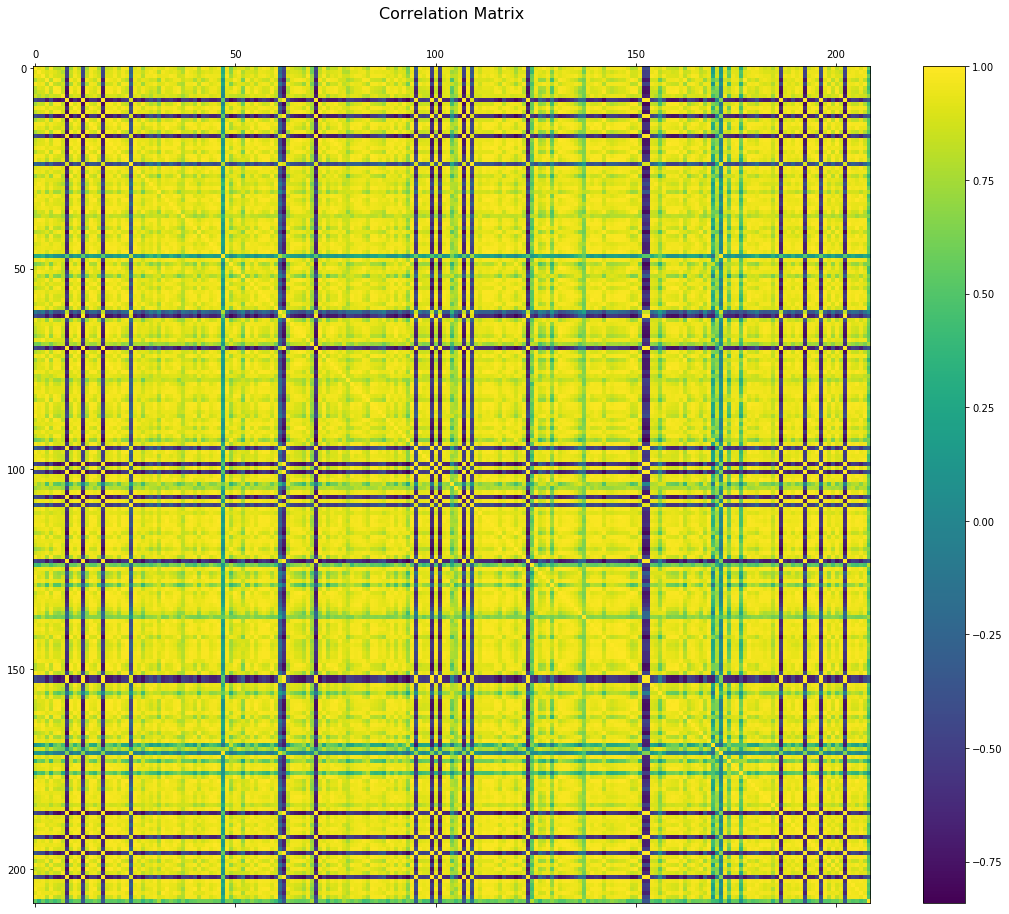

In [68]:
f = plt.figure(figsize=(19, 15))
plt.matshow(pivoted_GDP_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We then try to clusterize this correlation matrix in order to find countries whose GDP are correlated:

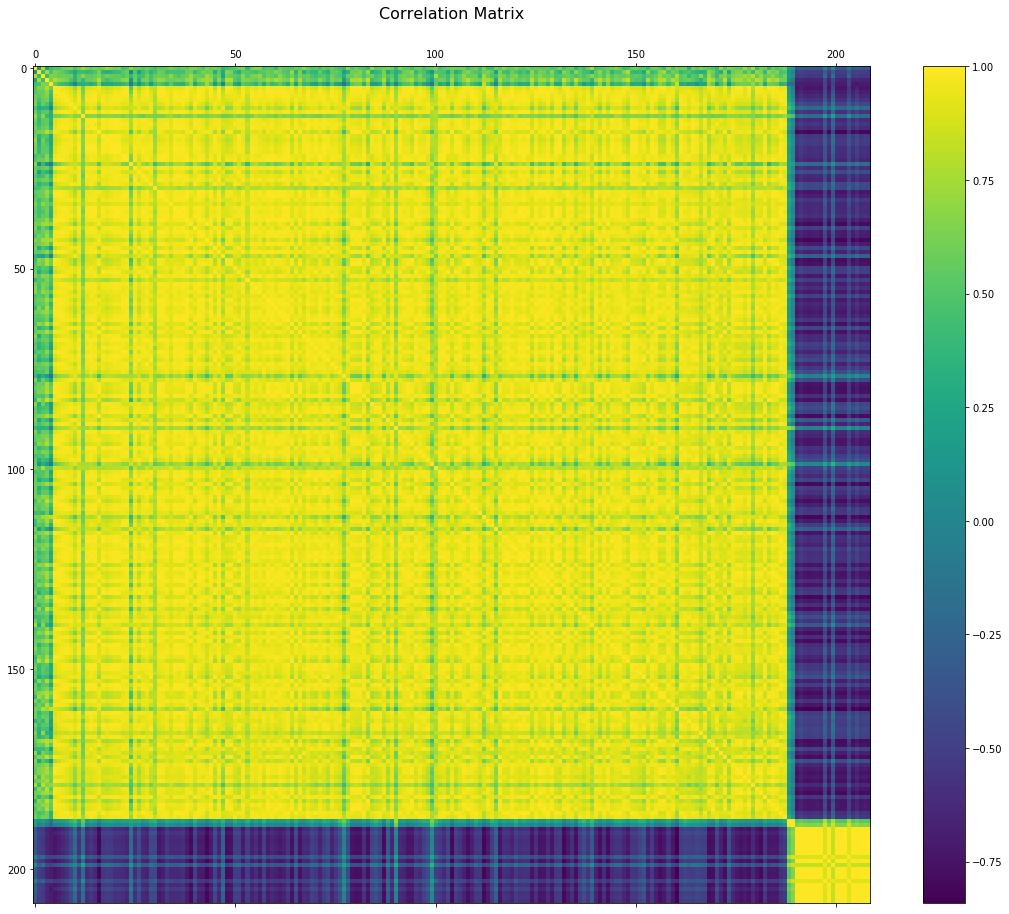

In [69]:
corr = pivoted_GDP_df.corr().values
pdist = spc.distance.pdist(corr)   # vector of ('55' choose 2) pairwise distances
linkage = spc.linkage(pdist, method='complete')
ind = spc.fcluster(linkage, 0.32*pdist.max(), 'distance')
columns = [pivoted_GDP_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
clusterised_df = pivoted_GDP_df.reindex(columns, axis=1)

f = plt.figure(figsize=(19, 15))
plt.matshow(clusterised_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We have found regions in which the GDP is highly correlated and between which the correlation coefficent is lower. We could refine the big clusters by iterating this method.

**Interpretation:** The correlation matrix of GDP contains lots of values that are very closed to one. This means that **GDP in two different countries have a trend to evolve the same way**. Therefore, we can say that the world countries have **strong enough trading relations** to make the GDP evolve the same way. The fact that we have found some **main clusters** could be interpreted as regions in which the **trading relations are more important**.

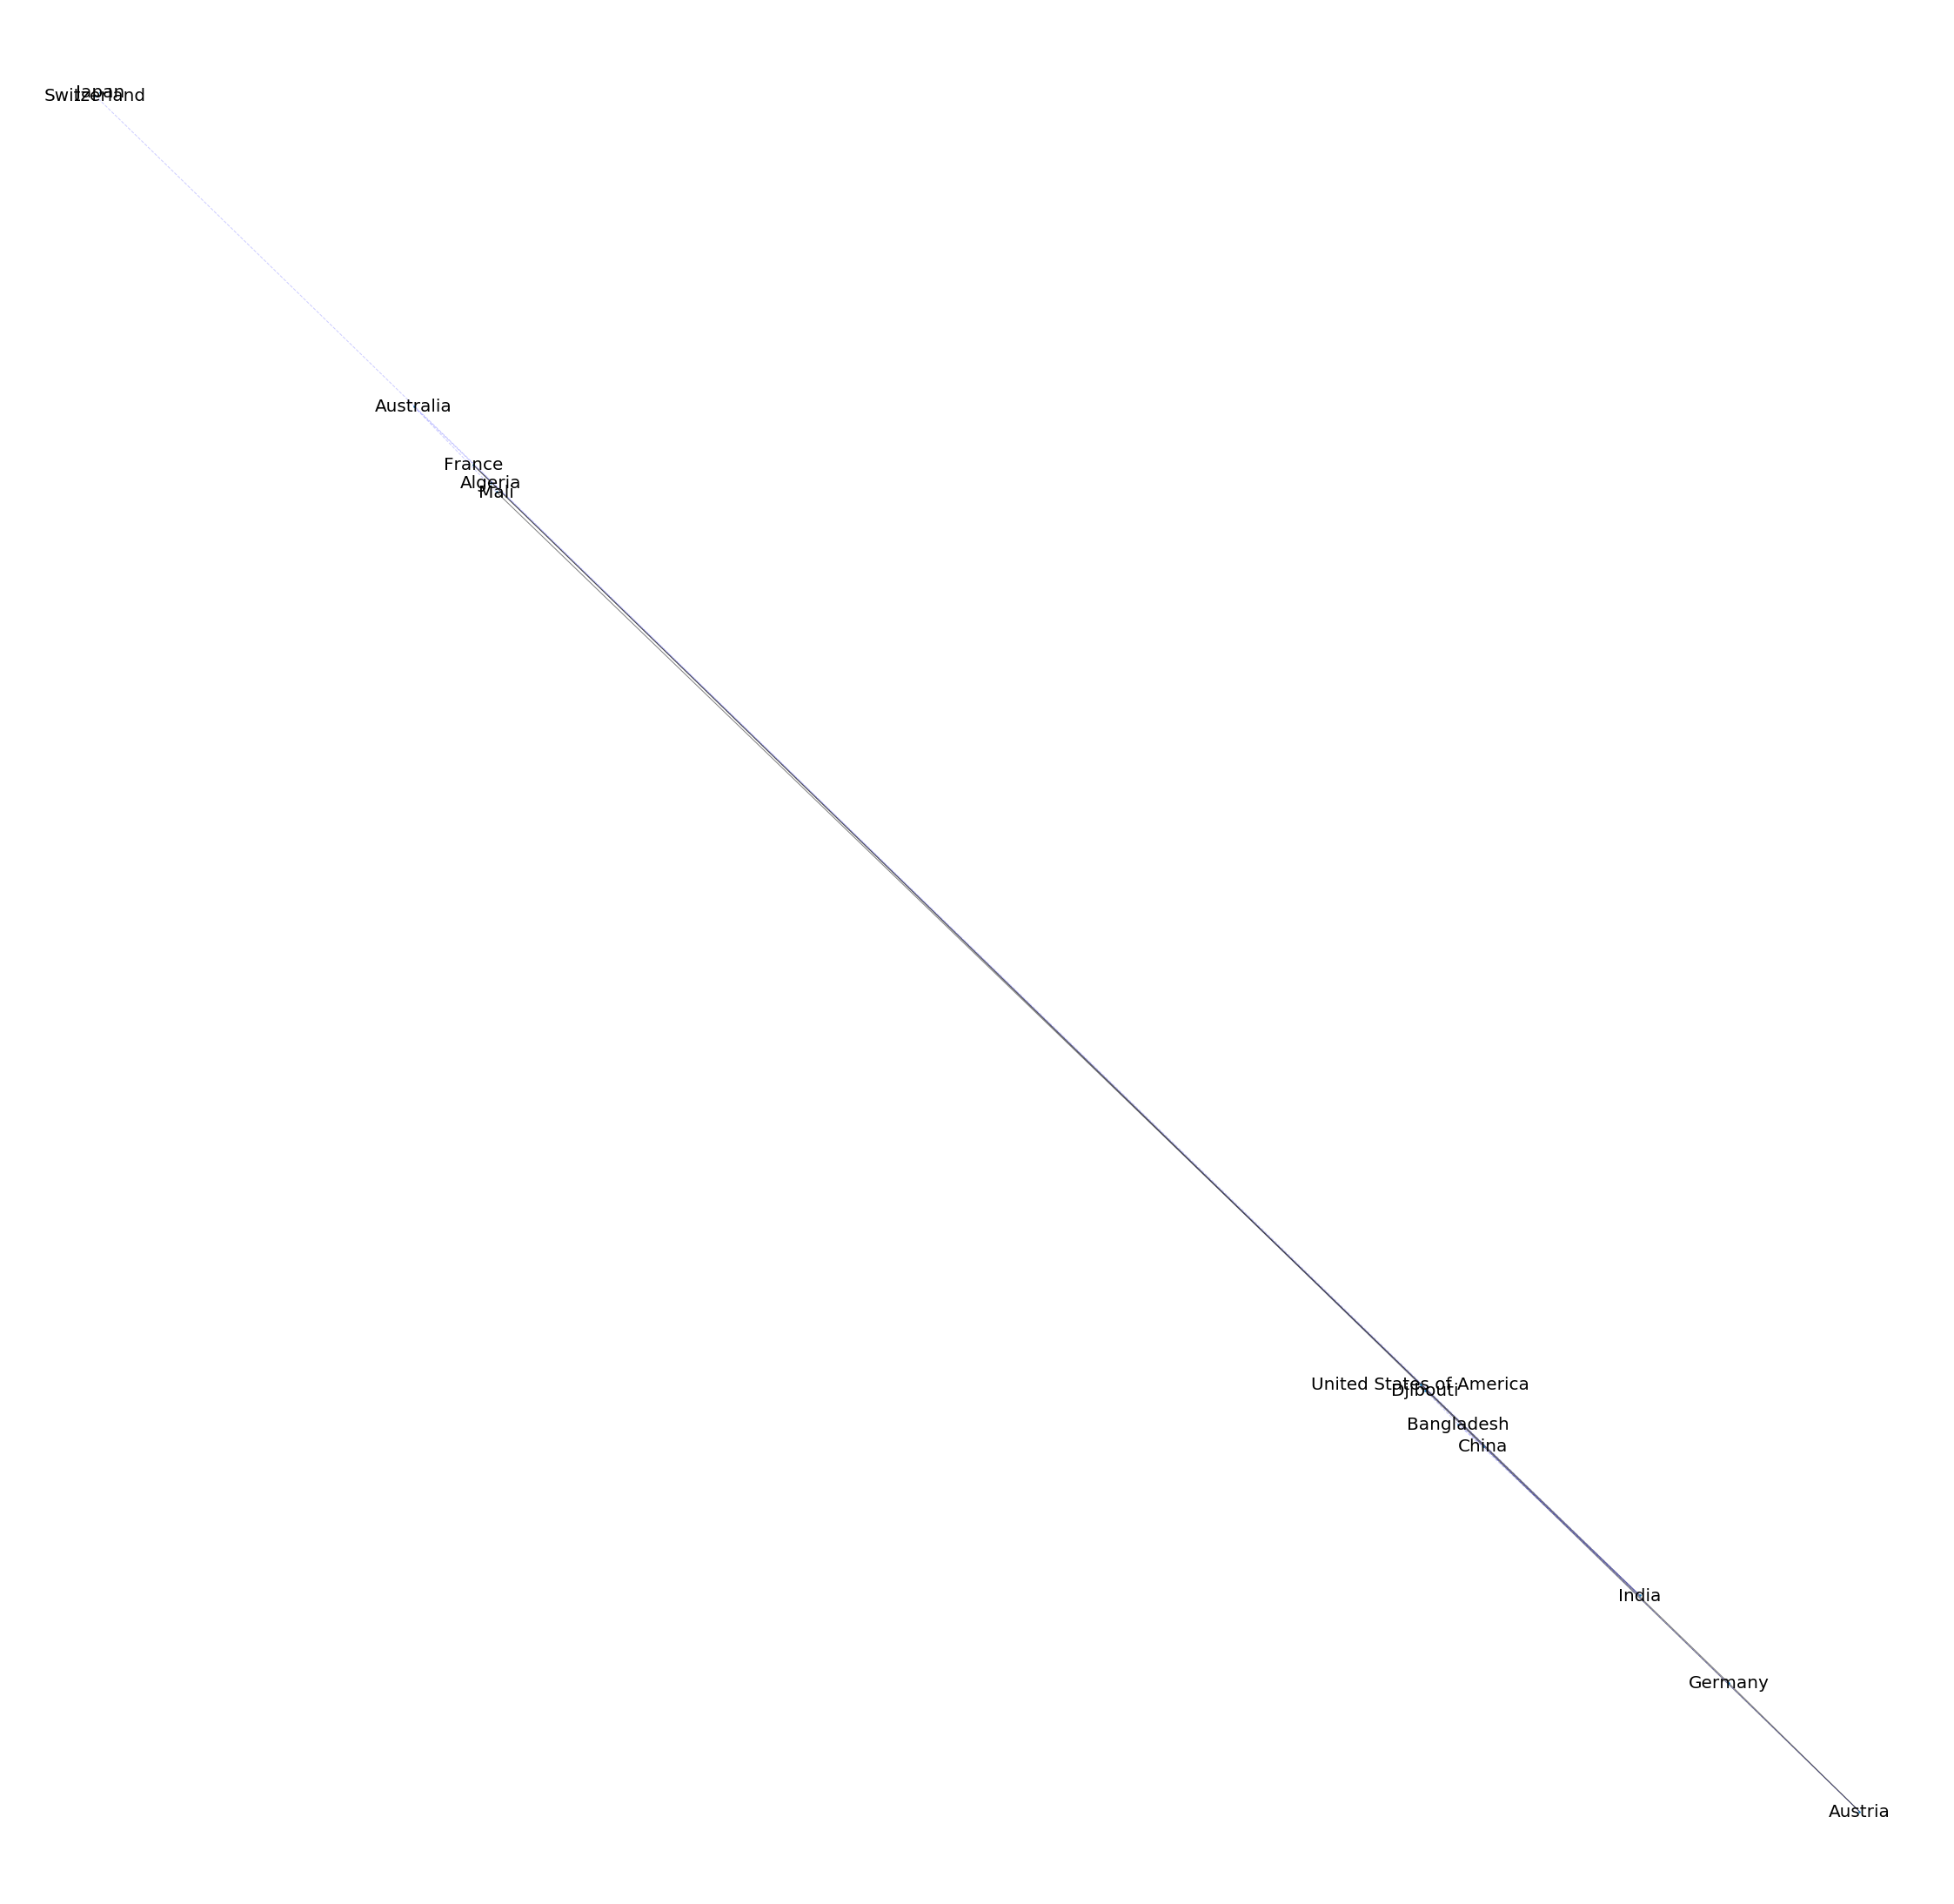

In [70]:
import networkx as nx


plt.figure(figsize=(40,40))

selected_countries = ['Algeria', 'Australia', 'Austria', 'Bangladesh', 'China',
                      'Djibouti', 'France', 'Germany', 'India', 'Japan', 'Mali',
                      'Switzerland', 'United States of America']

G =  nx.from_pandas_adjacency(pivoted_GDP_df[selected_countries].corr())

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.99]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if 0.98 < d['weight'] <= 0.99]

pos = nx.spring_layout(G, k=0.01185)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_shape='.')

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=1, alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=1, alpha=0.2, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()


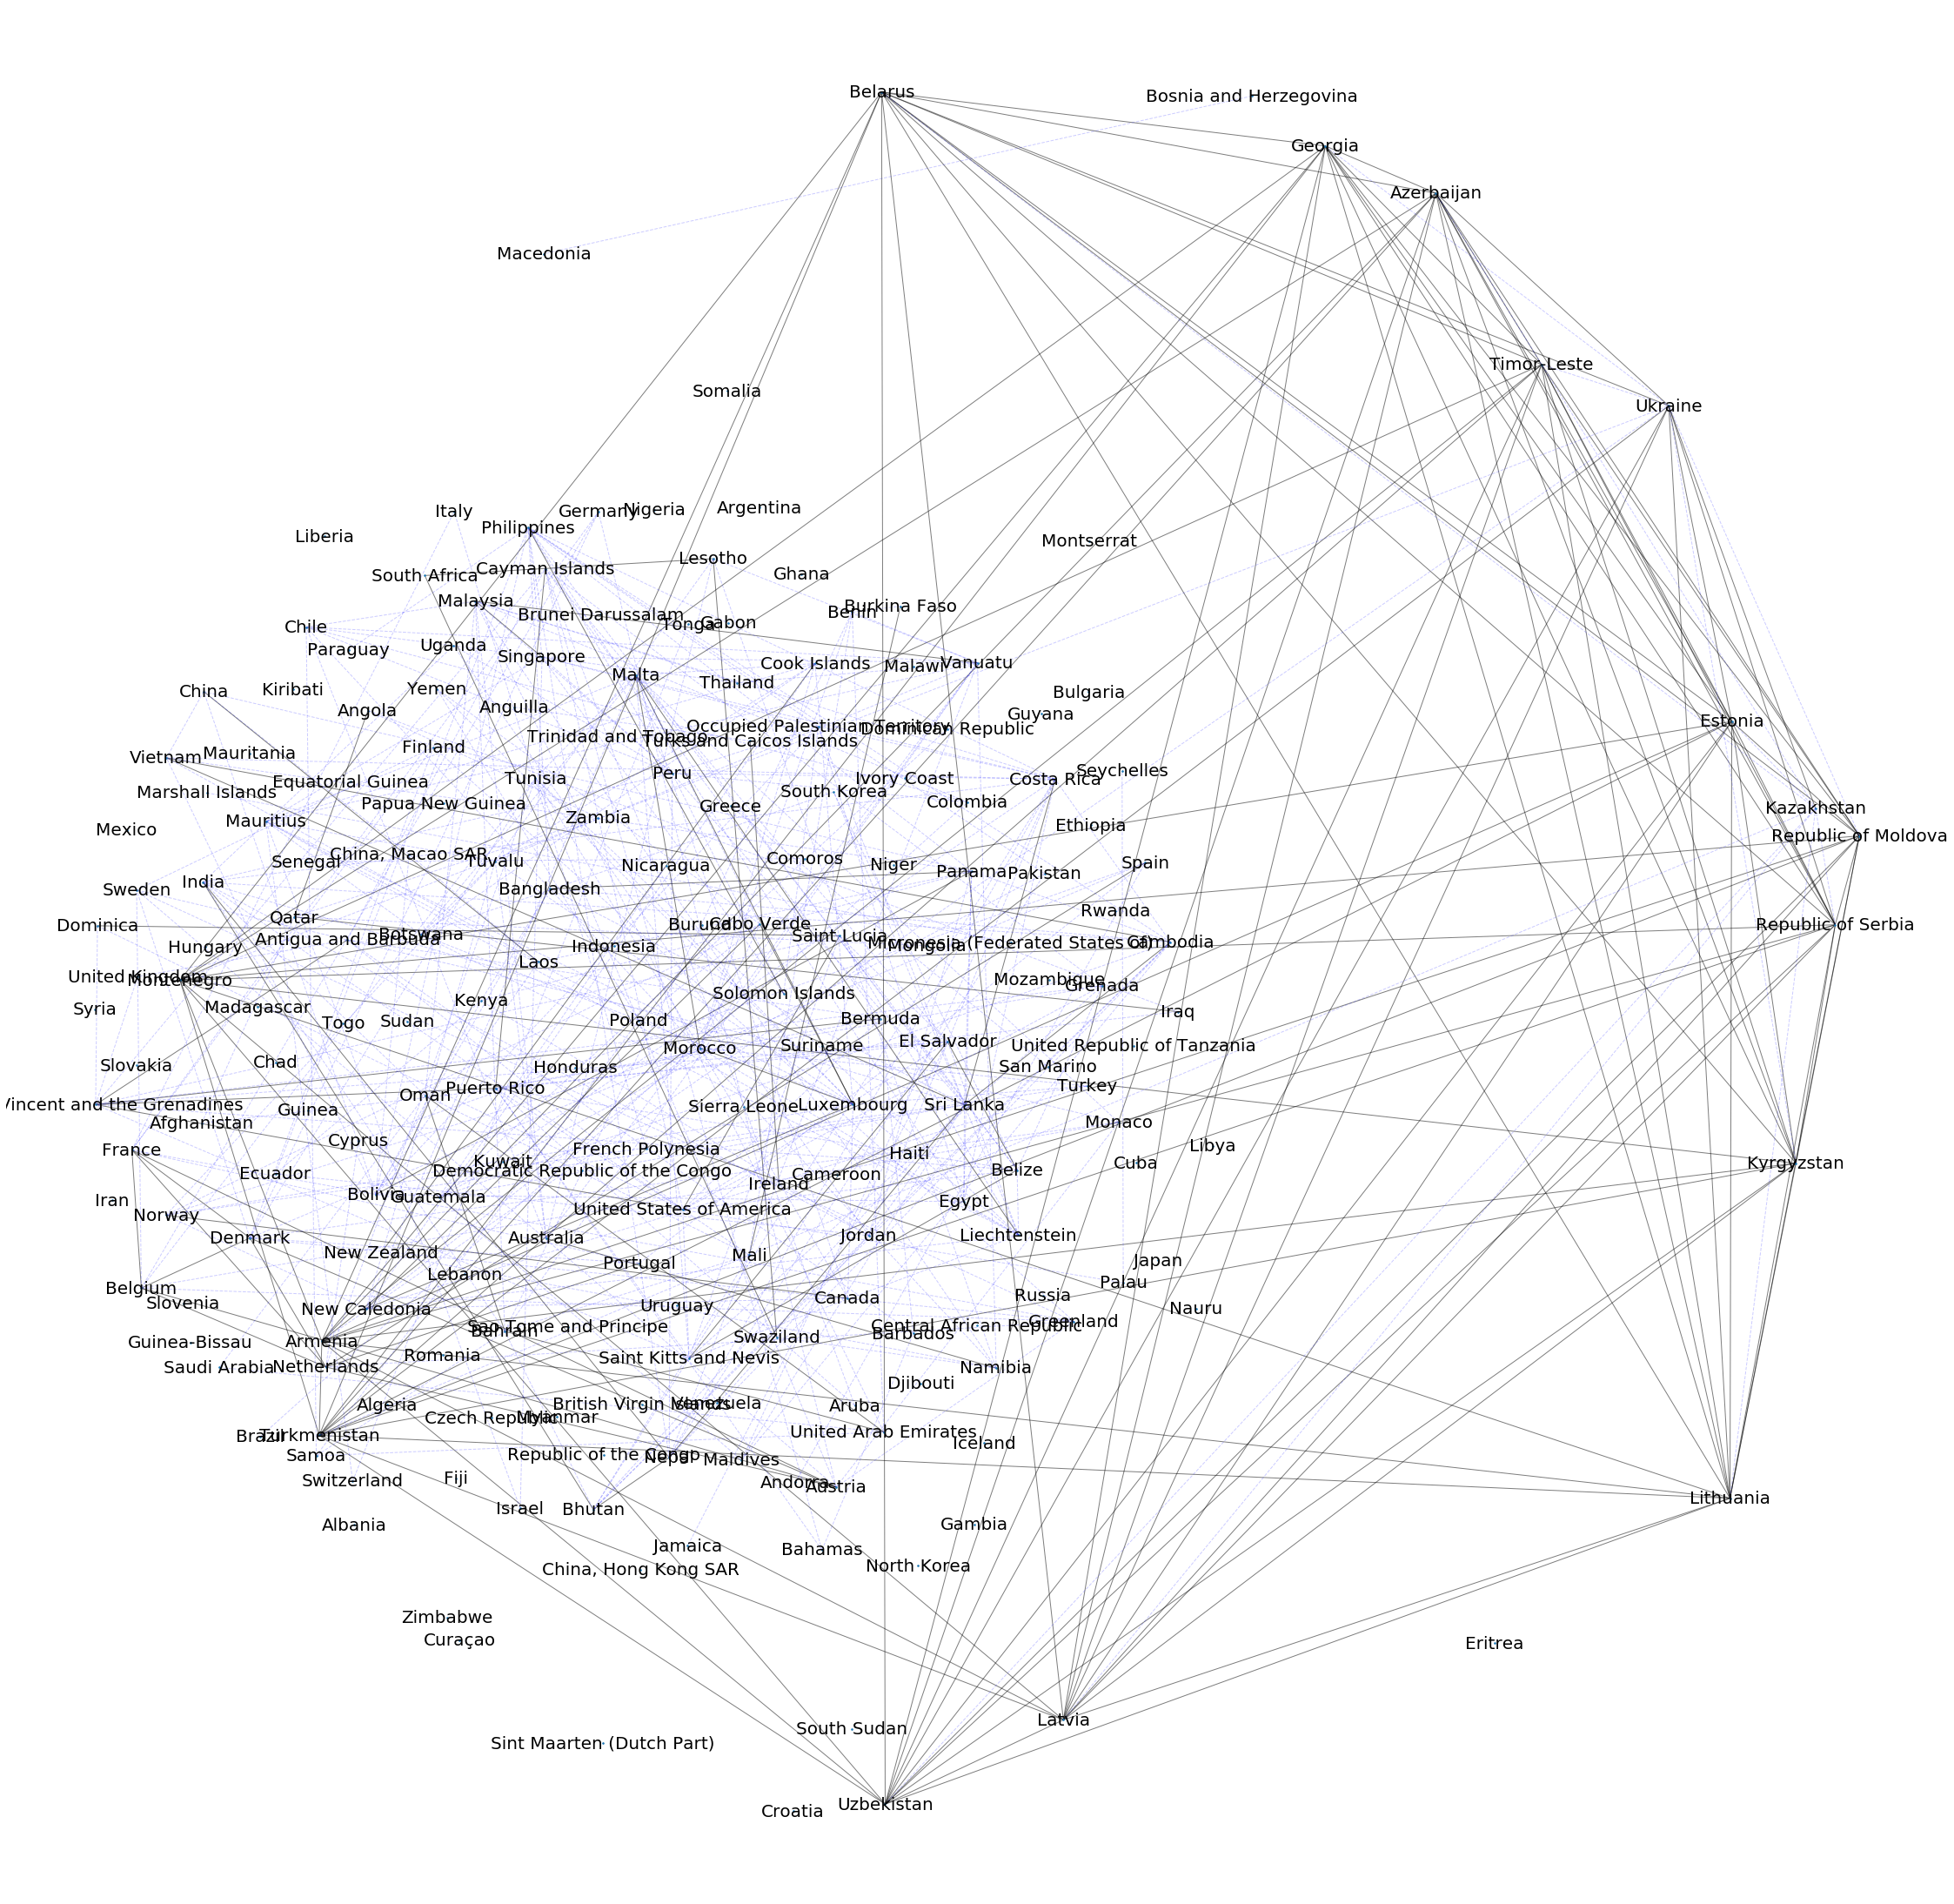

In [71]:
plt.figure(figsize=(40,40))

G =  nx.from_pandas_adjacency(pivoted_GDP_df.corr())

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.995]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if 0.99 < d['weight'] <= 0.995]

pos = nx.spring_layout(G, k=2)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_shape='.')

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=1, alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=1, alpha=0.2, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

#### 2.D. Economic classification of countries <a name="2D"></a>
Below, we plot the distribution of GDP over the world for the last decades:

In [72]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df["(GDP, million $)"]
interact(lambda x: visualise_world_data_folium(plot,'Value',x,'GDP [Mil USD]'),x=(1990,2010,1))

interactive(children=(IntSlider(value=2000, description='x', max=2010, min=1990), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

The countries with high **GDP** indeed correpond to the most **developped countries**. The **trends we can observe** from those plots look **very significant** (USSR dissolution, China economic growth, ...)

# 3. Descriptive analysis <a name='3'></a>
3. 
    1. [Identifying the most important features](#3A)
        1. [Feature selection and model fiting](#3Aa)
        2. [Results](#3Ab)
    2. [Where are the most important features produced?](#3B)
    3. [Who are net importers and exporters of the features of interest?](#3C)
    4. [How is the self sufficiency distributed for the selected features?](#3D)
    

### A. Identifying the most important features<a name='3A'></a>

  a. Feature selection and mode fitting <a name='3Aa'></a>

In [73]:

def create_target_and_covariate_df(path_to_pkl):
    '''
    path_to_pkl: path to the pickle file.
    outputs two dataframes, one for the independant variables one for the dependant variables
    '''
    
    uni_df = pd.read_pickle(path_to_pkl)
    uni_df = uni_df.drop(columns=['Area', 'Year'])
    target_variables_df = uni_df[['(GDP, million $)', '(Consumer price indices, %)']]
    covariates_df = uni_df.drop(columns=['(GDP, million $)', '(Consumer price indices, %)'])
    
    return covariates_df, target_variables_df


def drop_feature_pearson_correlation(threshold, target_variable, target_variable_name, dataframe):
    
    '''
    threshold: the minimum amount of correlation required to keep the feature
    target_variable_name: string GDP or CPI
    normalised_dataset: the normalised dataset of feature
    target_variable: pandas series that contains the value of the target_varibale_name
    that we add to the normalised dataset
    
    '''
    copy_dataframe = dataframe.copy()
    copy_dataframe[target_variable_name] = target_variable
    cor = copy_dataframe.corr()
    cor_target = abs(cor[target_variable_name])
    
    relevant_features = cor_target[cor_target > threshold]
    
    return list(relevant_features.keys())

def drop_too_corelated_featues(threshold, dataframe):
    
    corr_matrix = dataframe.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return dataframe.drop(dataframe[to_drop], axis=1)
    

def feature_augmentation(degree, covariates_df):
    poly = PolynomialFeatures(degree)
    output_nparray =  poly.fit_transform(covariates_df)

    
    output_df = pd.DataFrame(output_nparray, columns = poly.get_feature_names(covariates_df.columns))
    
    return output_df

def split_and_standardization_dataset(target_variables, covariates, test_size, random, type_return = 'numpy'  ):
    
    '''
    
    target_variables: pandas dataframe that contains the target variables
    covariates: pandas dataframe that contains the independant variables
    test_size: the proportion of the dataset to include in the test split
    type_return: 'numpy' if return numpy array, 'pandas' if return pandas dataframe
    '''
    target_variables_numpy = target_variables.to_numpy()
    covariates_numpy = covariates.to_numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(covariates_numpy, target_variables_numpy, test_size=test_size, random_state = random)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    if type_return == 'numpy':
        
        return X_train_normalized, X_test_normalized, Y_train, Y_test
    
    elif type_return == 'pandas':
        
        X_test_normalized_df = pd.DataFrame(X_test_normalized, columns = list(covariates.columns))
        X_train_normalized_df = pd.DataFrame(X_train_normalized,columns= list(covariates.columns))
        Y_train_df = pd.DataFrame(Y_train, columns= list(target_variables.columns))
        Y_test_df = pd.DataFrame(Y_test, columns= list(target_variables.columns))
        
        return X_train_normalized_df, X_test_normalized_df, Y_train_df, Y_test_df

def fit_model_lasso(regularisation_parameters, covariates_df, target_df, nb_fold_CV):
    
    lasso = Lasso()
    
    parameters = {'alpha': regularisation_parameters}
    
    lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = nb_fold_CV)
    lasso_regressor.fit(covariates_df, target_df)

    best_param = lasso_regressor.best_params_['alpha']
    print('The best regularization parameter is ', best_param)


    lasso = Lasso(alpha=best_param)
    lasso.fit(covariates_df, target_df)
    return lasso.coef_
    
    
    
def RFECV_lasso_2(covariate, target,  random, nb_fold = 5,):
    
    cols = list(covariate.columns)
    X_train_, X_test_, Y_train_, Y_test_ = split_and_standardization_dataset(target, covariate, 0.2, type_return='numpy', random = random)
    #print('shape of Y_train_', Y_train_.shape, 'type of Y_train_', type(Y_train_))
    model = Lasso()
    
    rfecv = RFECV(estimator = model, step = 1, cv = nb_fold, scoring = 'neg_mean_squared_error')
    rfecv.fit(X_train_, np.ravel(Y_train_))
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    temp = pd.Series(rfecv.support_,index = cols)
    selected_features = temp[temp==True].index

    print(selected_features)
    

    # plt.figure()
    # plt.xlabel("Number of features selected")
    # plt.ylabel("Cross validation score")
    # plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    # plt.show()
        
    return selected_features

In [99]:
def main(target_to_inspect = '(GDP, million $)'):

    RANDOM_SEED = 29
    
    reg_param = np.linspace(start = 0.01, stop= 1, num = 20)

    params = {

        'target' : target_to_inspect ,
        'name of target': 'GDP',
        'pearson correlation threshold': 0.4,
        'inter correlation threshold': 0.9, 
        'nb_fold_CV': 5, 
        'degree augmentation': 1,
        'regularization_parameter': reg_param
    }

    covariates_df, target_variables_df = create_target_and_covariate_df('./Scripts/Data/uni_df.pkl')
    target_variables_df.to_pickle('Scripts/Data/Results/target.pkl')

    ### Below we select the top 20 features in production:

    Production_cov_df = covariates_df.filter(regex= 'production|Production')
    summed_df = Production_cov_df.sum()
    keys = summed_df.keys()
    values = summed_df.values
    sorted_keys = [key for _,key in sorted(zip(values,keys))]
    Production_cov_df = Production_cov_df[sorted_keys[-20:]]
    selected_features_production = list(Production_cov_df.columns.values) # Selected features for top 20 prod features in volumne

    cropped_word_selected_prod = [" ".join(string.split()[:-3]) for string in selected_features_production] # Same as the list above with only the important words kept


    

   ### Below we are selecting the features in export that have been selected previously with the production
    export_df = covariates_df.filter(regex= 'export')
    

    columns_to_keep_export = []

    for column_export in list(export_df.columns.values):

        for columns_prod in cropped_word_selected_prod:

            if columns_prod in column_export:

                columns_to_keep_export.append(column_export)


    ### Below we are selecting the features in import that have been selected previously with the production
    import_df = covariates_df.filter(regex= 'import')
    

    columns_to_keep_import = []

    for column_import in list(import_df.columns.values):

        for columns_prod in cropped_word_selected_prod:

            if columns_prod in column_import:

                columns_to_keep_import.append(column_import)

    


    final_features_kept = selected_features_production + columns_to_keep_export + columns_to_keep_import  # All the selected features
   
    covariates_df = covariates_df[final_features_kept]
    


    list_selected_features_GDP = drop_feature_pearson_correlation(params['pearson correlation threshold'], target_variables_df[params['target']], params['name of target'], covariates_df)
    covariate_reduced_df = covariates_df[list_selected_features_GDP[:-1]]
    covariate_reduced_df = drop_too_corelated_featues(params['inter correlation threshold'], covariate_reduced_df)
    covariate_reduced_df.to_pickle("Scripts/Data/Results/reduced_df_2.pkl")
    print('list of selected features after reduction', list(covariate_reduced_df.columns.values))
    
    regularisation_parameters = params['regularization_parameter']

    target_df = target_variables_df[params['target']]

    nb_fold_CV = params['nb_fold_CV']

    param_lasso = fit_model_lasso(regularisation_parameters, covariate_reduced_df, target_df, nb_fold_CV = nb_fold_CV )

    keys = list(covariate_reduced_df.columns.values)
    
    values = param_lasso
   
    return dict(zip(keys, values))

weights=main('(GDP, million $)')

list of selected features after reduction ['Soybeans Crops Production tonnes', 'Tomatoes Crops Production tonnes', 'Maize Crops Production tonnes', 'Turkeys Livestock production Head', 'Maize Food export quantities tonnes', 'Maize, green Food export quantities tonnes', 'Wheat Food export quantities tonnes', 'Cattle Live animals import quantities Head', 'Oats Food import quantities tonnes', 'Pigs Live animals import quantities Head', 'Tomatoes Food import quantities tonnes', 'Turkeys Live animals import quantities Head']
The best regularization parameter is  0.01


In [75]:
weights

{'Soybeans Crops Production tonnes': 0.01690455171988309,
 'Tomatoes Crops Production tonnes': 0.04600299893471081,
 'Maize Crops Production tonnes': 0.019112555979080622,
 'Turkeys Livestock production Head': 0.00045609049200983894,
 'Maize Food export quantities tonnes': -0.06316454222878924,
 'Maize, green Food export quantities tonnes': 52.08283849392848,
 'Wheat Food export quantities tonnes': 0.007579959466075064,
 'Cattle Live animals import quantities Head': 0.03663454785851843,
 'Oats Food import quantities tonnes': 0.4837657071630528,
 'Pigs Live animals import quantities Head': 0.05776106945901834,
 'Tomatoes Food import quantities tonnes': 2.568655777314169,
 'Turkeys Live animals import quantities Head': 0.04929538371588097}

**Above, we see the features identified as the most important by our regression model**

We find that the  goods that most influence the GDP are soybean, tomatoes, Maize, Wheat , Cattle live animals and pigs amongst other. 

It is an interesting result that is easily understandable. Take soybean for example. This crop is one of the most produced. The mains exporter are the US, Brasil and Argentina and the main importer is China. Around 330 millions tonnes of soybean was produced in 2018. It is vastly used to feed animals. It is thus coherent to see such an important good be selected by our model. We see also that wheat, oats, cattle live and pigs are present. This again is easily understandable. It is sufficient to look at our eating habit to convince ourself that those goods plays an important role in the GDP. 

## B. Where are the most important features produced? <a name='3B'></a>

After having identified the most important features with our prediction model, we want to have a look as to where they are produced.  

The first step is to select to columns corresponding to the production of the features of interest within our dataframe.

In [76]:
features=list(weights.keys())
pickle_file="Scripts/Data/uni_df.pkl"
df=pickle.load(open(pickle_file,'rb'))
df=df.set_index(['Area','Year'])

#To select the production of the features of interest, the dataframe is filtered with each feature. To reduce computation cost, the result is stored in a dictionnary and when all the features are treated turned into
#a pandas DataFrame

dic_to_plot={}

for feature in features:
    
    if 'Production' in feature or 'production' in feature:
        if len(df.filter(regex=feature).columns)==0:
            print('{} not found'.format(c))
        else:
            dic_to_plot.update(df.filter(regex=feature).to_dict())
            
    else:
        s=re.split(' Food| Live',feature)[0]
        cols=[c for c in df.columns if re.split(' Crop| Food| Live',c)[0]==s and re.search('Production|production',c)]
        
        if cols==0:
            print('{} not found'.format(feature))
        else:
            dic_to_plot.update(df[cols].to_dict())
            
prod_to_plot=pd.DataFrame(dic_to_plot)
prod_to_plot=prod_to_plot.reset_index().rename(columns={'level_0':'Area','level_1':'Year'})

#### Let's dive into the maps!

In [77]:
columns=[c for c in prod_to_plot.columns if c!='Area' and c!='Year']
for c in columns:
    print(c)
    display(interact(lambda x : visualise_world_data_folium(prod_to_plot,c,x,c,log2=True),x=(1970,2014,1)))


Soybeans Crops Production tonnes


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Tomatoes Crops Production tonnes


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Maize Crops Production tonnes


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Turkeys Livestock production Head


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Maize, green Crops Production tonnes


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Wheat Crops Production tonnes


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Cattle Livestock production Head


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Oats Crops Production tonnes


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Pigs Livestock production Head


interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Globally, all features that we identified seem to follow a common trend. The biggest producers are in almost all categories China, the USA and brazil. Russia, France, Spain, Germany seem to get closer to their volumes. The rest of Europe is situated in the second or third tier of producer as well as the other developed countries (Australia, Canada, south American countries). In the majority of categories, north and south African countries are situated in the some orders of magnitude as developed countries. A general trend to observe is that central African countries seem to produce very few resources in comparison to the rest of the world. The only feature going against this general description seems to be the cattle. The production of cattle appears to be very well distributed throughout the world. The production of pigs also seem well distributed throughout the world except for countries excluding pork from their diet for religious purposes. The phenomenon might be explained by the increased difficulty in transporting these goods. Live animals and meat transport is much more complicated than grain, vegetables or forage. Meaning that the countries would generally produce what they need in term of meat and rather import crops or vegetables.  

The general trend we observe is that developed countries are bigger producers. This makes sense considering how we selected these features. Our regression model gives us the features that are connected with a high GDP thus the features selected will be markers of rich countries.

What can be found surprising is the stability of the producer ranking throughout the years. The top producers 50 years ago are still the top producers nowadays. It is also worth noting that globally, even though the ranking does not change, the sheer production volume follows a growing trend.

In [78]:
#Exporting the results as HTML files
import os
import shutil

#Generate result files

#if needed, creating result directory
if not os.path.exists('./Scripts/Data/Results'):
    os.mkdir('./Scripts/Data/Results')
if not os.path.exists('./Scripts/Data/Results/Producers'):
        os.mkdir('./Scripts/Data/Results/Producers')
        
for c in prod_to_plot.columns:
    if c!='Year' and c!='Area':
        
        #if the dir already exists, remove it and create fresh one
        if os.path.exists('./Scripts/Data/Results/Producers/{}'.format(c)):
            shutil.rmtree('./Scripts/Data/Results/Producers/{}'.format(c))
        #wait for the deletion to be complete
        while os.path.exists('./Scripts/Data/Results/Producers/{}'.format(c)):
            continue
        os.mkdir('./Scripts/Data/Results/Producers/{}'.format(c))
        
        for year in range(1970,2015,1):
            m=visualise_world_data_folium(prod_to_plot,c,year,c,log2=True)
            save_name='./Scripts/Data/Results/Producers/{}/{}_{}.html'.format(c,c,year)
            m.save(save_name)

In [79]:
def plot_trend_production(prod_to_plot,production_elt):
    
    prod_to_plot = prod_to_plot[prod_to_plot["Year"] < 2014]#years after 2014 dont contain relevant data
    
    #select the 10 countries that produced the more since 1990
    countries=list(prod_to_plot[prod_to_plot["Year"] >1990][["Area",production_elt]]#1990 after the end of ussr
                   .groupby("Area")
                   .sum()
                   .sort_values(by=production_elt,ascending=False)
                   .reset_index()
                   .head(10)["Area"])
    
    prod_to_plot.sort_values(by='Year', inplace=True)
    fig, ax = plt.subplots(figsize=(10,5))

    for c in countries:
        prod_to_plot[prod_to_plot.Area==c].plot(x="Year",
                                                  y=production_elt,
                                                  kind="line", ax=ax)
    _ = ax.set_title(f'{production_elt}' )
    _ = ax.legend(countries, loc = 'upper left')
    return ax

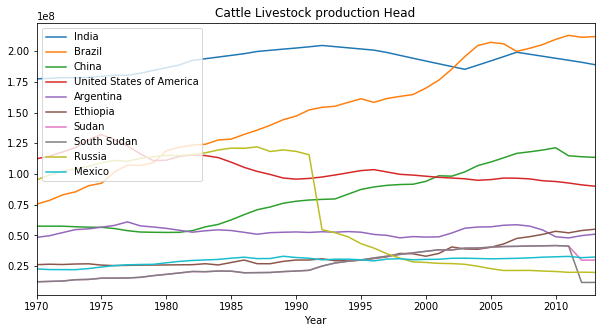

In [80]:
plot_trend_production(prod_to_plot,'Cattle Livestock production Head')


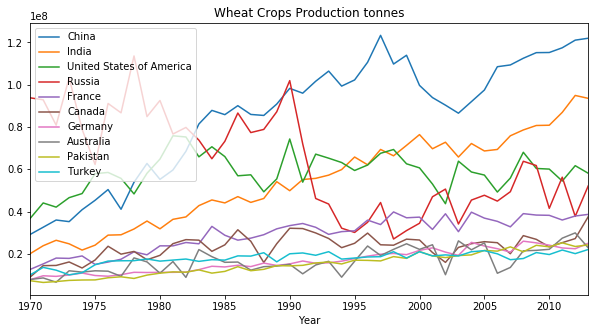

In [81]:
plot_trend_production(prod_to_plot,'Wheat Crops Production tonnes')

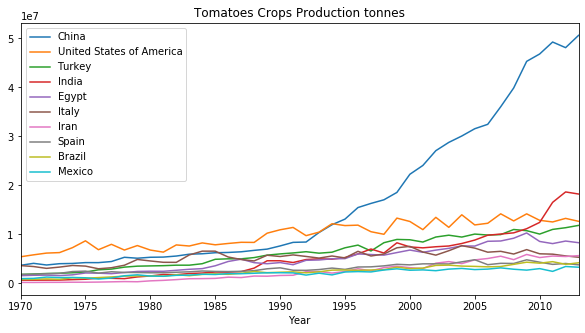

In [82]:
plot_trend_production(prod_to_plot,'Tomatoes Crops Production tonnes')

## C.  Who are the importers and exporters of the features of interest? <a name="3C"></a>

For the next milestone, this part will be put to the end of the file and conducted for **specific agricultural features** (e.g. trade of crop most highly correlated to GDP) after the **most important ones** have been **identified**.

In [83]:
def net_import_export(uni_df,weights):
    
    #This method return a dataframe containing the net trade balance for each country for each year for the features of interest
    
    exports_df=uni_df.set_index(['Area','Year']).filter(regex="export")
    imports_df=uni_df.set_index(['Area','Year']).filter(regex="import")

    e_cols=[]
    i_cols=[]
    popped=[]
    for feature in weights.keys():
        if feature not in popped:
            s=re.split(' Food| Live| Crops',feature)[0]
            for f in features:
                f_split=re.split(' Food| Live| Crops',f)[0]
                if f_split==s:
                    popped.append(f)
            e_cols.extend([c for c in list(exports_df.columns) if re.split(' Food| Live| Crops',c)[0]==s])
            i_cols.extend([c for c in list(imports_df.columns) if re.split(' Food| Live| Crops',c)[0]==s])

    exports_df=exports_df[e_cols]
    imports_df=imports_df[i_cols]

    e_col_dic={c:re.split(' Food| Live| Crops',c)[0] for c in exports_df.columns}
    i_col_dic={c:re.split(' Food| Live| Crops',c)[0] for c in imports_df.columns}



    exports_df=exports_df.rename(columns=e_col_dic)
    imports_df=imports_df.rename(columns=i_col_dic)

    net_df=exports_df.subtract(imports_df)
    
    return net_df

In [84]:
net_df =net_import_export(uni_df,weights)
net_df.reset_index(inplace=True)

for c in net_df.columns:
    if c!='Year' and c!='Area':
        #print(c,'\n')
        display(interact(lambda x : visualise_world_data_folium(net_df,c,x,c+" [Tonnes or Heads]",log2=True),x=(1970,2014,1)))

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

interactive(children=(IntSlider(value=1992, description='x', max=2014, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

In [85]:
def plot_trend_import_export(net_df, imported_and_exported_elt, area1, area2, area3, area4):
    net_df = net_df[net_df["Year"] < 2014]
    select_area1 = net_df['Area']== area1
    select_area2 = net_df['Area']== area2
    select_area3 = net_df['Area']== area3
    select_area4 = net_df['Area']== area4
    ax = net_df[select_area1].plot(x ='Year', y=imported_and_exported_elt, kind = 'line')
    ax = net_df[select_area2].plot(x ='Year', y=imported_and_exported_elt, kind = 'line', ax=ax)
    ax = net_df[select_area3].plot(x ='Year', y=imported_and_exported_elt, kind = 'line', ax=ax)
    ax = net_df[select_area4].plot(x ='Year', y=imported_and_exported_elt, kind = 'line', ax=ax)
    _ = ax.set_title(imported_and_exported_elt+' net export in Tonnes/Head for different countries for the period 1970-2015')
    _ = ax.legend([area1, area2, area3, area4])


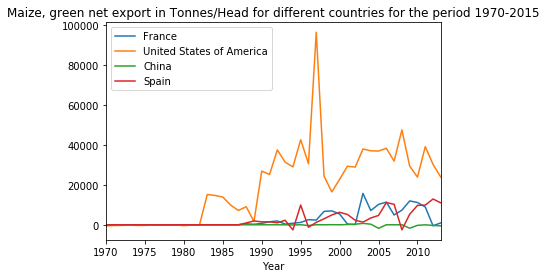

In [86]:

plot_trend_import_export(net_df, 'Maize, green', 'France', 'United States of America', 'China', 'Spain')

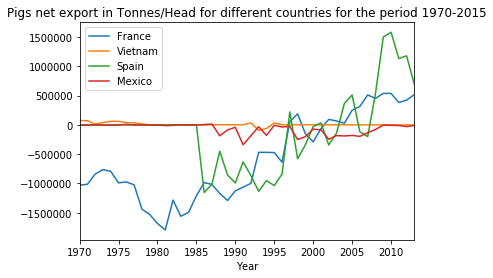

In [87]:
plot_trend_import_export(net_df,'Pigs', 'France', 'Vietnam', 'Spain', 'Mexico')

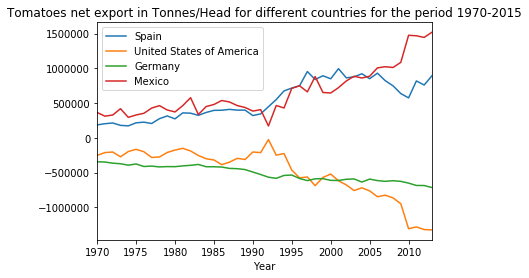

In [88]:
plot_trend_import_export(net_df,'Tomatoes', 'Spain', 'United States of America', 'Germany', 'Mexico')

In [89]:
#Exporting the results as HTML files
import os
import shutil

#Generate result files

#if needed, creating result directory
if not os.path.exists('./Scripts/Data/Results'):
    os.mkdir('./Scripts/Data/Results')
if not os.path.exists('./Scripts/Data/Results/Trade'):
        os.mkdir('./Scripts/Data/Results/Trade')
        
for c in net_df.columns:
    if c!='Year' and c!='Area':
        
        #if the dir already exists, remove it and create fresh one
        if os.path.exists('./Scripts/Data/Results/Trade/{}'.format(c)):
            shutil.rmtree('./Scripts/Data/Results/Trade/{}'.format(c))
        #wait for the deletion to be complete
        while os.path.exists('./Scripts/Data/Results/Trade/{}'.format(c)):
            continue
        os.mkdir('./Scripts/Data/Results/Trade/{}'.format(c))
        
        for year in range(1970,2014,1):
            m=visualise_world_data_folium(net_df,c,year,c,log2=True)
            save_name='./Scripts/Data/Results/Trade/{}/{}_{}.html'.format(c,c,year)
            m.save(save_name)

## D. How is the self sufficiency distributed for the selected features? <a name="3D"></a>
In this chapter, we take a look at the self suficiency score of the countries around the world and we focus on the agricultural features identified by our model.

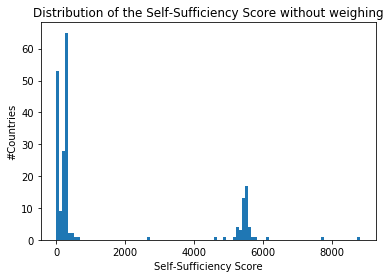

In [90]:
pickle_file="Scripts/Data/uni_df.pkl"
df=pickle.load(open(pickle_file,'rb'))
sc=compute_self_suficiency(df,weights, True)
sc.reset_index(inplace=True)
sc=sc.rename(columns={'level_0':'Area','level_1':'Year'})


## self-sufficiency in 2012 with weights
sc_plots= sc[sc["Year"] == 2012]

plt.xlabel('Self-Sufficiency Score')
plt.ylabel('#Countries')
plt.title('Distribution of the Self-Sufficiency Score without weighing')
_ = plt.hist(sc_plots['Agg'], bins=100)



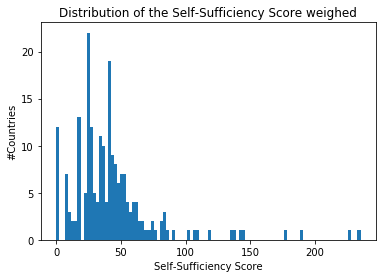

In [91]:
pickle_file="Scripts/Data/uni_df.pkl"
df=pickle.load(open(pickle_file,'rb'))
sc=compute_self_suficiency(df,weights)
sc.reset_index(inplace=True)
sc=sc.rename(columns={'level_0':'Area','level_1':'Year'})

## self-sufficiency in 2012 without weights
sc_plots= sc[sc["Year"] == 2012]

plt.xlabel('Self-Sufficiency Score')
plt.ylabel('#Countries')
plt.title('Distribution of the Self-Sufficiency Score weighed')
_ = plt.hist(sc_plots['Agg'], bins=100)

As seen in the histograms, the unweighted score seems to make more sense, because the values obtained by weighing creates two clusters of countries, which don't make much sense. 

In [96]:
interact(lambda x: visualise_world_data_folium(sc,'Agg',x,'Self Sufficiency score',log2=True),x=(1970,2013))

interactive(children=(IntSlider(value=1991, description='x', max=2013, min=1970), Output()), _dom_classes=('wi…

<function __main__.<lambda>(x)>

Unlike the production ranking, the self sufficiency score seems to be pretty instable. It is interesting to note that the countries who were by far top producers do no stand out early on. For instance China does not appear in the highest score until 1990. The most surprising results come from African countries such as South Africa, the United Republic of Tanzania, Nigeria and the Ivory Coast that constantly have a score competing with the richest countries which was unexpected. Even though the general trend tends to show that richer countries are more independent, there are outliers and the score seems to have a pretty high variance

In [97]:
# This field generates the results and exports them as HTML files (1 map per year)

import os
import shutil

#Generate result files

#if needed, create result directories
if not os.path.exists('./Scripts//Data/Results'):
    os.mkdir('./Scripts/Data/Results')
    
#if directory already exists delete it
if os.path.exists('./Scripts/Data/Results/SelfSufficiency'):
    shutil.rmtree('./Scripts/Data/Results/SelfSufficiency')

#While loop necessary to wait until the tree is deleted
while os.path.exists('./Scripts/Data/Results/SelfSufficiency'):
    continue
    
os.mkdir('./Scripts/Data/Results/SelfSufficiency')
    

for year in range(1970,2014,1):
            m=visualise_world_data_folium(sc,'Agg',year,'Self Sufficiency Score',log2=True)
            save_name='./Scripts/Data/Results/SelfSufficiency/self_suf_{}.html'.format(year)
            m.save(save_name)

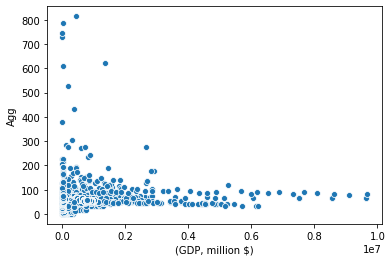

In [94]:
#Correlating Self-sufficiency with GDP

self_df = sc.copy()
uni_df = pd.read_pickle("Scripts/Data/uni_df.pkl")
Value_of_interest = uni_df[['(GDP, million $)', '(Consumer price indices, %)', 'Area', 'Year']]
#print("col self", self_df.columns)


merge_df = pd.merge(Value_of_interest, self_df,  how='left', left_on=['Area','Year'], right_on = ['Area','Year'])
merge_df = merge_df[merge_df['(GDP, million $)'] < 10000000 ]
merge_df = merge_df[merge_df['Agg'] < 1000 ]
merge_df = merge_df[merge_df['Agg'] > 0 ]
#print('mrge col', merge_df.columns)

merge_df['CPI_rank'] = merge_df['(Consumer price indices, %)'].rank(ascending=False)
merge_df['AGG_rank'] = merge_df['Agg'].rank(ascending = False)
#print(merge_df)
test_df = merge_df
#test_df = merge_df.loc[merge_df['Year'] == 2000]
ax = sns.scatterplot(x='(GDP, million $)', y="Agg", data=test_df)
plt.show()



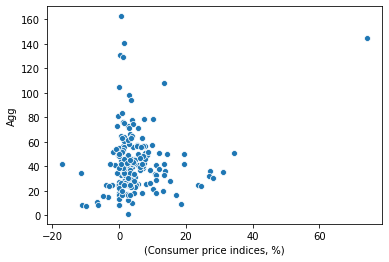

In [95]:
#Correlating Self-sufficiency with CPI

self_df = sc.copy()
uni_df = pd.read_pickle("Scripts/Data/uni_df.pkl")
Value_of_interest = uni_df[['(GDP, million $)', '(Consumer price indices, %)', 'Area', 'Year']]
#print("col self", self_df.columns)


merge_df = pd.merge(Value_of_interest, self_df,  how='left', left_on=['Area','Year'], right_on = ['Area','Year'])
merge_df = merge_df[merge_df['(Consumer price indices, %)'] < 100 ]
merge_df = merge_df[merge_df['Agg'] < 10000 ]
merge_df = merge_df[merge_df['Agg'] > 0 ]
#print('mrge col', merge_df.columns)

merge_df['CPI_rank'] = merge_df['(Consumer price indices, %)'].rank(ascending=False)
merge_df['AGG_rank'] = merge_df['Agg'].rank(ascending = False)
#print(merge_df)

test_df = merge_df.loc[merge_df['Year'] == 2010]
ax = sns.scatterplot(x='(Consumer price indices, %)', y="Agg", data=test_df)
plt.show()


Both scatter plots above although not being entirely randomly distributed, don't show any usable distribution between our self sufficiency score and the GDP or CPI which could be explained by the presence of import quantities within our features of interest. Large import quantities will significantly reduce the score of rich countries, thus biasing the repartition of the scatter plot. There seem to be some kind of pattern which could lead to interesting conclusions, however there are too many variables to attempt a complete interpretation of these results within the scope of this project.